### CAPSTONE PROJECT - Computer Vision: PNEUMONIA DETECTION CHALLENGE

**PROBLEM STATEMENT**

• **DOMAIN**: Health Care

• **CONTEXT**: Computer vision can be used in health care for identifying diseases. In Pneumonia detection we need to detect Inflammation of the lungs. In this challenge, you’re required to build an algorithm to detect a visual signal for pneumonia in medical images. Specifically, your algorithm needs to automatically locate lung opacities on chest radiographs.

• **DATA DESCRIPTION**:
- In the dataset, some of the features are labeled “Not Normal No Lung Opacity”. This extra third class indicates that while pneumonia was
determined not to be present, there was nonetheless some type of abnormality on the image and oftentimes this finding may mimic the
appearance of true pneumonia. Dicom original images: - Medical images are stored in a special format called DICOM files (*.dcm). They contain a combination of header metadata as well as underlying raw image arrays for pixel data.
- Dataset has been attached along with this project. Please use the same for this capstone project.
- Original link to the dataset : https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/data [ for your reference
only ]. You can refer to the details of the dataset in the above link
- Acknowledgements: https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/overview/acknowledgements.

• **PROJECT OBJECTIVE**: Design a DL based algorithm for detecting pneumonia.

In [1]:
import os
import numpy as np
import pandas as pd

#Visualization
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline
import seaborn as sns

import math

#transform & resize image
from skimage import measure
from skimage.transform import resize

#!pip install pydicom
import pydicom as dcm

from glob import glob

import cv2

from pathlib import Path

#Tensorflow
import tensorflow as tf
from tensorflow.keras.applications.mobilenet import preprocess_input
import tensorflow.keras.utils as pltUtil
from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import Layer, Concatenate, UpSampling2D, Conv2D, Reshape, BatchNormalization, Activation
from tensorflow.keras.models import Model

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Concatenate, UpSampling2D,Conv2D,Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras import Sequential

#For MobileNet
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input

#For ResNet50
from tensorflow.keras.applications.resnet import ResNet50

#For tunning of model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler

#For Metrics & Report
from sklearn import metrics
from sklearn.metrics import classification_report

#Importing the required libraries to build the model
from tensorflow import keras 
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization

from keras.layers import Conv2D # swipe across the image by 1
from keras.layers import MaxPooling2D # swipe across by pool size
from keras.layers import Flatten, GlobalAveragePooling2D,GlobalMaxPooling2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

#encoding
from sklearn.preprocessing import LabelBinarizer

#train test split
from sklearn.model_selection import train_test_split

from tqdm import tqdm_notebook

import warnings; 
warnings.filterwarnings('ignore')

# SET RANDOM SEED
np.random.seed(2022)

#### Import the data.

In [2]:
#csv files
class_info = pd.read_csv('D:/Nikhila/PGP - AIML/2. Projects/10. Capstone Project/CV Capstone/stage_2_detailed_class_info.csv')
train_labels = pd.read_csv('D:/Nikhila/PGP - AIML/2. Projects/10. Capstone Project/CV Capstone/stage_2_train_labels.csv')

#path
PATH = 'D:/Nikhila/PGP - AIML/2. Projects/10. Capstone Project/CV Capstone/'
os.chdir(PATH)

TRAIN_IMAGES = os.path.join(PATH + 'stage_2_train_images/')
TEST_IMAGES = os.path.join(PATH + 'stage_2_test_images/')

#Output files will be stored here
OUTPUT_DIR = os.path.join(PATH + 'output/')

#### Milestone 1:

#### Exploratory Data Analysis

#####  1.Shape of the dataset

In [3]:
print(f'Shape of the Train Labels dataframe: {train_labels.shape[0]} rows and {train_labels.shape[1]} columns')
print(f'Shape of the Class info dataframe: {class_info.shape[0]} rows and {class_info.shape[1]} columns')

Shape of the Train Labels dataframe: 30227 rows and 6 columns
Shape of the Class info dataframe: 30227 rows and 2 columns


##### 2.Duplicate number of records in the dataset

In [4]:
print('Number of duplicates in Train Labels dataframe: {}'.format(len(train_labels) - (train_labels['patientId'].nunique())))
print('Number of duplicates in Class info dataframe: {}'.format(len(class_info) - (class_info['patientId'].nunique())))

Number of duplicates in Train Labels dataframe: 3543
Number of duplicates in Class info dataframe: 3543


##### 3.Unique number of records in the dataset

In [5]:
print('Number of unique records in Train Labels dataframe: {}'.format(train_labels['patientId'].nunique()))
print('Number of unique records in Class info dataframe: {}'.format(class_info['patientId'].nunique()))

Number of unique records in Train Labels dataframe: 26684
Number of unique records in Class info dataframe: 26684


##### 4.Head of the dataset

In [6]:
print('Train labels dataframe:\n'); display(train_labels.head())
print('\nClass info dataframe:\n'); display(class_info.head())

Train labels dataframe:



patientId      x      y  width  height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1


Class info dataframe:



patientId                         class
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  No Lung Opacity / Not Normal
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd  No Lung Opacity / Not Normal
2  00322d4d-1c29-4943-afc9-b6754be640eb  No Lung Opacity / Not Normal
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5                        Normal
4  00436515-870c-4b36-a041-de91049b9ab4                  Lung Opacity

**Observation:** We have NaN present in the bounding boxes in train label dataframe.

##### 5.Numbers of nulls in bounding boxes

In [7]:
print('Nulls in bounding boxes: {}'.format(train_labels[['x', 'y', 'width', 'height']].isnull().sum().to_dict())) 
print('Null value counts for the targets: {}'.format(train_labels['Target'].value_counts().to_dict()))

Nulls in bounding boxes: {'x': 20672, 'y': 20672, 'width': 20672, 'height': 20672}
Null value counts for the targets: {0: 20672, 1: 9555}


**Observation:** Train labels with target as 0 (negative) does not have bounding boxes.

##### 6.Distribution of 'Target' and 'class' column

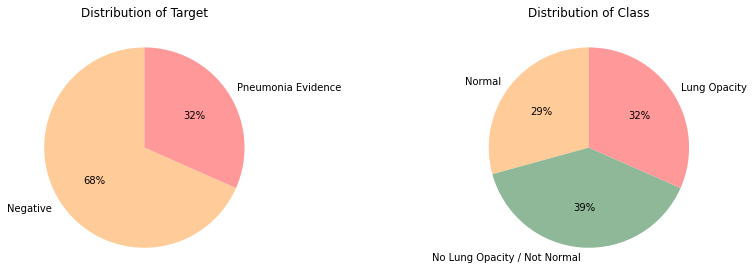

In [8]:
fig = plt.figure(figsize = (12, 4))

ax = fig.add_subplot(121)
g = (train_labels['Target'].value_counts()
    .plot(kind = 'pie', autopct = '%.0f%%', 
          labels = ['Negative', 'Pneumonia Evidence'], 
          colors = ['#ffcc99', '#ff9999'], 
          startangle = 90, 
          title = 'Distribution of Target', fontsize = 10)
    .set_ylabel(''))

ax = fig.add_subplot(122)
g = (class_info['class'].value_counts().sort_index(ascending = False)
    .plot(kind = 'pie', autopct = '%.0f%%', 
          colors = ['#ffcc99', '#8EB897', '#ff9999'], 
          startangle = 90, title = 'Distribution of Class', 
          fontsize = 10)
    .set_ylabel(''))

plt.tight_layout()

**Observation** 
- Imbalanced dataset.
- In class info dataframe, ***Normal & No lung Opacity/Not Normal*** can be considered as ***Negative*** which constitues to 68%.

#### 7.Number of patientID's per bounding boxes in the dataset

In [9]:
bboxes = train_labels.groupby('patientId').size().to_frame('number_of_boxes').reset_index()
train_labels = train_labels.merge(bboxes, on = 'patientId', how = 'left')

(bboxes.groupby('number_of_boxes').size().to_frame('number_of_patientIDs_per_boxes').reset_index()
.set_index('number_of_boxes')
.sort_values(by = 'number_of_boxes'))

number_of_patientIDs_per_boxes
number_of_boxes                                
1                                         23286
2                                          3266
3                                           119
4                                            13

**Observation:** 
- 23286 patientIds have 1 bounding boxes.
- While 3266, 119 & 13 patients have 2, 3 & 4 bounding boxes respectively.

In [10]:
#Example
train_labels[train_labels.patientId=='c1f7889a-9ea9-4acb-b64c-b737c929599a']

patientId      x      y  width  height  \
30225  c1f7889a-9ea9-4acb-b64c-b737c929599a  570.0  393.0  261.0   345.0   
30226  c1f7889a-9ea9-4acb-b64c-b737c929599a  233.0  424.0  201.0   356.0   

       Target  number_of_boxes  
30225       1                2  
30226       1                2

In [11]:
class_info[class_info.patientId=='c1f7889a-9ea9-4acb-b64c-b737c929599a']

patientId         class
30225  c1f7889a-9ea9-4acb-b64c-b737c929599a  Lung Opacity
30226  c1f7889a-9ea9-4acb-b64c-b737c929599a  Lung Opacity

#### 8.Number of class associated with each patientID

In [12]:
print('Each patientId is associated with only {} class'.format(class_info.groupby(['patientId'])['class'].nunique().max()))

Each patientId is associated with only 1 class


#### Merge train_labels, class_info & train_images dataframe

In [13]:
train_class = pd.concat([train_labels, class_info['class']], axis = 1)

print('Shape of the dataframe after the merge: {}'.format(train_class.shape))
print('Shape of the dataframe with unique records after the merge: {}'.format(train_class['patientId'].nunique()))

Shape of the dataframe after the merge: (30227, 8)
Shape of the dataframe with unique records after the merge: 26684


In [14]:
images = pd.DataFrame({'path': glob(os.path.join(TRAIN_IMAGES, '*.dcm'))})
images['patientId'] = images['path'].map(lambda x: os.path.splitext(os.path.basename(x))[0])

print('Number of images in the training folder: {}'.format(images.shape[0]))
print('Columns in the training images dataframe: {}'.format(list(images.columns)))

assert images.shape[0] == len(list(set(train_class['patientId']))), 'Number of training images should be equal to the unique patientIds we have'

Number of images in the training folder: 26684
Columns in the training images dataframe: ['path', 'patientId']


In [15]:
train_class = train_class.merge(images, on = 'patientId', how = 'left')
print('Shape of the train_class dataframe after merge: {}'.format(train_class.shape))
del images

Shape of the train_class dataframe after merge: (30227, 9)


#### Map training and testing images to its classes and its annotations.

Images are stored in DICOM (.dcm) format which is an international standard to transmit, store, retrieve, print, process, and display medical imaging information. Digital Imaging and Communications in Medicine (DICOM) makes medical imaging information interoperable. We will make use of pydicom package here to read the images.

In [16]:
sample_patient_id = train_labels['patientId'][0]
dcm_file = TRAIN_IMAGES + '{}.dcm'.format(sample_patient_id)
dcm_data = dcm.read_file(dcm_file)

print(dcm_data)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 202
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time      

**Observation** - 
- The dicom file contains some of the information that can be used for further analysis such as Patient's Sex, Patient's Age, body part examined, view position and modality. 
- Size of this image is rows & columns(1024 x 1024).

#### Feature extraction from the image files

In [17]:
# Helper function to get additional features from dicom images
def get_tags(data, path):
    images = os.listdir(path)
    for _, name in tqdm_notebook(enumerate(images)):
        img_path = os.path.join(path, name)
        img_data = dcm.read_file(img_path)
        idx = (data['patientId'] == img_data.PatientID)
        data.loc[idx,'PatientSex'] = img_data.PatientSex
        data.loc[idx,'PatientAge'] = pd.to_numeric(img_data.PatientAge)
        data.loc[idx,'BodyPartExamined'] = img_data.BodyPartExamined
        data.loc[idx,'ViewPosition'] = img_data.ViewPosition
        data.loc[idx,'Modality'] = img_data.Modality

In [18]:
print('Adding features such as {} from training images'.format(('PatientSex', 'PatientAge', 'BodyPartExamined', 'ViewPosition', 'Modality')))
get_tags(train_class, TRAIN_IMAGES)

Adding features such as ('PatientSex', 'PatientAge', 'BodyPartExamined', 'ViewPosition', 'Modality') from training images


0it [00:00, ?it/s]

In [19]:
#Saving for further analysis
train_class.to_pickle('./output/train_feature_engineered.pkl')

#reading the saved file
train_class = pd.read_pickle('./output/train_feature_engineered.pkl')
train_class.shape

(30227, 14)

In [20]:
train_class.head()

patientId      x      y  width  height  Target  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0   
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0   
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0   
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0   
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1   

   number_of_boxes                         class  \
0                1  No Lung Opacity / Not Normal   
1                1  No Lung Opacity / Not Normal   
2                1  No Lung Opacity / Not Normal   
3                1                        Normal   
4                2                  Lung Opacity   

                                                path PatientSex  PatientAge  \
0  D:/Nikhila/PGP - AIML/2. Projects/10. Capstone...          F        51.0   
1  D:/Nikhila/PGP - AIML/2. Projects/10. Capstone...          F        48.0   
2  D:/Nikhila/PGP - AIML/2. Projects/10. Capstone...          M        19.0   
3  D:/Nikhila/PGP - AIML/2. Projects/10. Capstone...          M        28.0   
4  D:/Nikhila/PGP - AIML/2. Projects/10. Capstone...          F        32.0   

  BodyPartExamined ViewPosition Modality  
0            CHEST           PA       CR  
1            CHEST           PA       CR  
2            CHEST           AP       CR  
3            CHEST           PA       CR  
4            CHEST           AP       CR

##### 1.Unique values present in 'BodyPartExamined' column

In [21]:
print('Unique value in BodyPartExamined column is: {}'.format(train_class['BodyPartExamined'].unique()[0]))

Unique value in BodyPartExamined column is: CHEST


##### 2.Unique values present in 'Modality' column

In [22]:
print('Unique value in Modality column is: {}'.format(train_class['Modality'].unique()[0]))

Unique value in Modality column is: CR


##### 3. Understand about 'PatientAge' column

###### a) Checking outliers

Minimum PatientAge in the training dataset: 1.0
Maximum PatientAge in the training dataset: 155.0



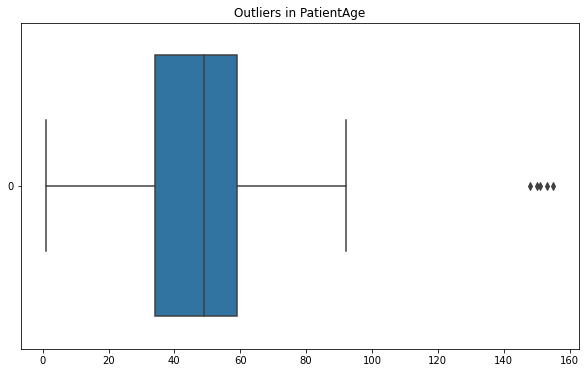

In [23]:
print('Minimum PatientAge in the training dataset: {}'.format(train_class['PatientAge'].min()))
print('Maximum PatientAge in the training dataset: {}'.format(train_class['PatientAge'].max()))

print()
fig = plt.figure(figsize = (10, 6))
ax = sns.boxplot(data = train_class['PatientAge'], orient = 'h').set_title('Outliers in PatientAge')

**Observation** - We can trim value to a specified lower and upper threshold. So an upper threshold of 100 in PatientAge would mean those outlier values being converted to 100.

In [24]:
train_class['PatientAge'] = train_class['PatientAge'].clip(train_class['PatientAge'].min(), 100)
train_class['PatientAge'].describe().astype(int)

count    30227
mean        46
std         16
min          1
25%         34
50%         49
75%         59
max        100
Name: PatientAge, dtype: int32

##### b) Distribution of  'PatientAge' column

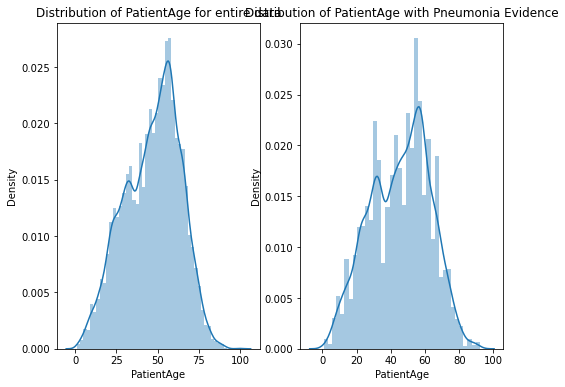

In [25]:
fig = plt.figure(figsize = (8, 6))

ax = fig.add_subplot(121)
g = (sns.distplot(train_class['PatientAge'])
    .set_title('Distribution of PatientAge for entire data'))

ax = fig.add_subplot(122)
g = (sns.distplot(train_class.loc[train_class['Target'] == 1, 'PatientAge'])
    .set_title('Distribution of PatientAge with Pneumonia Evidence'))

 **Observation** - Distribution peaks for age group 40-70 both overall and with Pneumonia Evidence.

##### c) Creating bins for 'PatientAge' column to understand the distribution

In [26]:
train_class['AgeBins'] = pd.cut(train_class['PatientAge'], bins = 4, precision = 0, labels = ['0-25', '26-50', '51-75', '76-100'])

display(pd.concat([train_class['AgeBins'].value_counts().sort_index().rename('Counts of Age Bins for entire data'), 
                   train_class.loc[train_class['Target'] == 1, 'AgeBins'].value_counts().sort_index().rename('Counts of Age Bins with Pneumonia Evidence')], axis = 1))

Counts of Age Bins for entire data  \
0-25                                  3972   
26-50                                12157   
51-75                                13318   
76-100                                 780   

        Counts of Age Bins with Pneumonia Evidence  
0-25                                          1478  
26-50                                         3917  
51-75                                         3895  
76-100                                         265

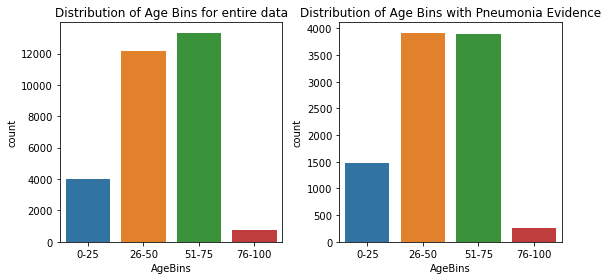

In [27]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (8, 4))
g = sns.countplot(x = train_class['AgeBins'], ax = ax1).set_title('Distribution of Age Bins for entire data')
g = sns.countplot(x = train_class.loc[train_class['Target'] == 1, 'AgeBins'], ax = ax2).set_title('Distribution of Age Bins with Pneumonia Evidence')
plt.tight_layout()

##### d)  Display images with bounding box for 'AgeBins' column

In [28]:
def bboxes_scatter(df1, df2, text1, text2):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (13, 8))
    fig.subplots_adjust(top = 0.85)
    fig.suptitle('Plotting centers of lung opacity\n{} & {}'.format(text1, text2))
    df1.plot.scatter(x = 'xw', y = 'yh', ax = ax1, alpha = 0.8, marker = '.', 
                   xlim = (0, 1024), ylim = (0, 1024), color = 'green')
    ax1.set_title('Centers of Lung Opacity\n{}'.format(text1))
    for i, row in df1.iterrows():
        ax1.add_patch(Rectangle(xy = (row['x'], row['y']),
                            width = row['width'], height = row['height'], 
                            alpha = 3.5e-3, color = 'yellow'))
    plt.title('Centers of Lung Opacity\n{}'.format(text2))
    df2.plot.scatter(x = 'xw', y = 'yh', ax = ax2, alpha = 0.8, marker = '.',
                   color = 'brown',  xlim = (0, 1024), ylim = (0, 1024))
    ax2.set_title('Centers of Lung Opacity\n{}'.format(text2))
    for i, row in df2.iterrows():
        ax2.add_patch(Rectangle(xy = (row['x'], row['y']),
                             width = row['width'], height = row['height'],
                             alpha = 3.5e-3, 
                             color = 'yellow'))
    plt.show()

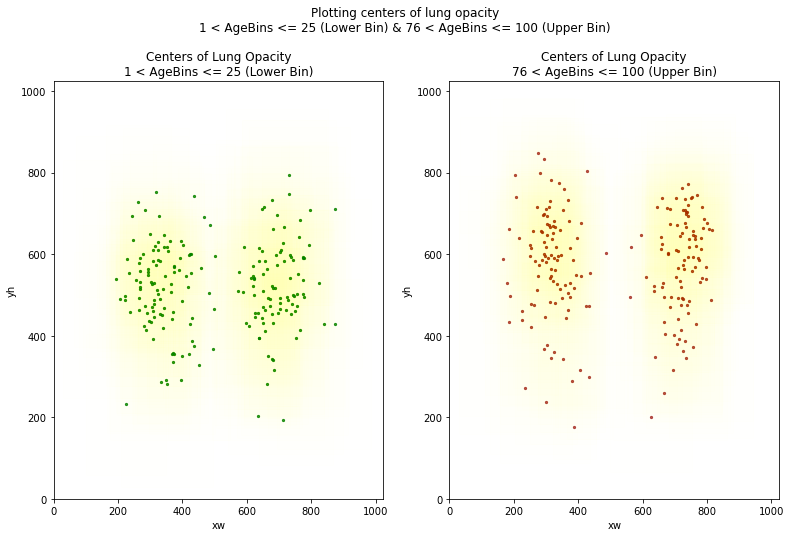

In [29]:
# Creating a dataframe with columns for center of the rectangles
bboxes = train_class[train_class['Target'] == 1]
bboxes['xw'] = bboxes['x'] + bboxes['width'] / 2
bboxes['yh'] = bboxes['y'] + bboxes['height'] / 2

df1 = bboxes[bboxes['AgeBins'] == '0-25'].sample(200)
df2 = bboxes[bboxes['AgeBins'] == '76-100'].sample(200)
bboxes_scatter(df1, df2, '1 < AgeBins <= 25 (Lower Bin)', '76 < AgeBins <= 100 (Upper Bin)')

##### 4.Combining 'PatientAge' & 'PatientGender' column

In [30]:
display(pd.concat([train_class['PatientSex'].value_counts(normalize = True).round(2).sort_values().rename('% Gender for entire data'), 
                   train_class.loc[(train_class['Target'] == 1), 'PatientSex']
                   .value_counts(normalize = True).round(2).sort_index().rename('% Gender with Pneumonia Evidence')], axis = 1))

% Gender for entire data  % Gender with Pneumonia Evidence
F                      0.43                              0.42
M                      0.57                              0.58

#####  Display images with bounding box.

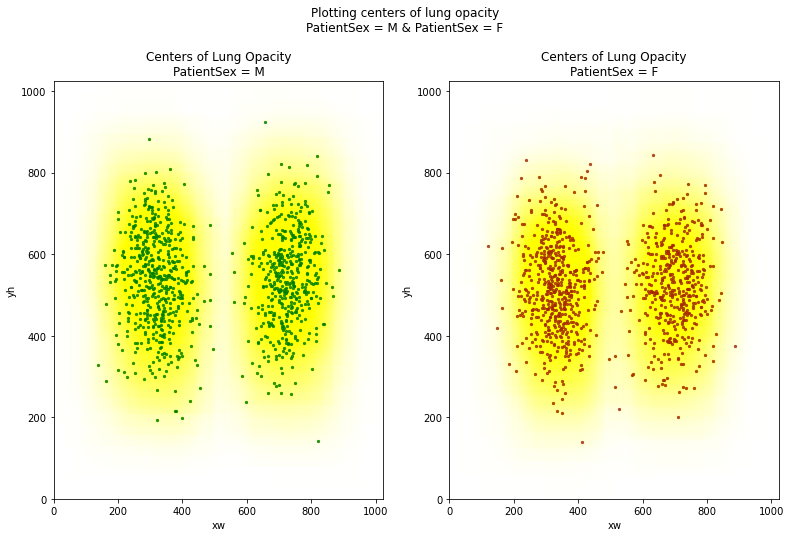

In [31]:
df1 = bboxes[bboxes['PatientSex'] == 'M'].sample(1000)
df2 = bboxes[bboxes['PatientSex'] == 'F'].sample(1000)
bboxes_scatter(df1, df2, 'PatientSex = M', 'PatientSex = F')

In [32]:
#Dropping the other features from train_class dataframe and save that as a pickle file
train_class.drop(['BodyPartExamined', 'Modality', 'AgeBins'], inplace = True, axis = 1)
train_class.to_pickle('./output/train_class_features.pkl')
train_class.shape

(30227, 12)

##### 5. Distributions of 'ViewPosition' column

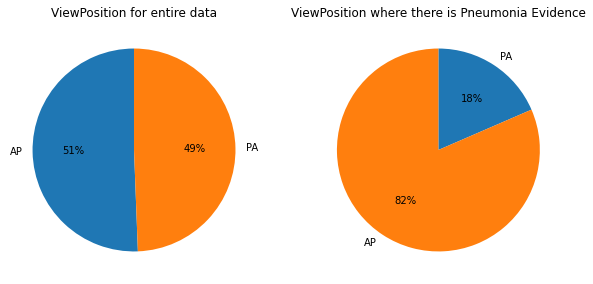

In [33]:
fig = plt.figure(figsize = (10, 8))

ax = fig.add_subplot(121)
g = (train_class['ViewPosition'].value_counts()
    .plot(kind = 'pie', autopct = '%.0f%%',  
          startangle = 90,
          title = 'ViewPosition for entire data', 
          fontsize = 10)
    .set_ylabel(''))

ax = fig.add_subplot(122)
g = (train_class.loc[train_class['Target'] == 1, 'ViewPosition']
     .value_counts().sort_index(ascending = False)
    .plot(kind = 'pie', autopct = '%.0f%%', 
          startangle = 90, counterclock = False, 
          title = 'ViewPosition where there is Pneumonia Evidence', 
          fontsize = 10)
    .set_ylabel(''))

**Observation** - Overall ViewPosition is almost equally distributed but when Target=1, most of the view position are AP.

#####  Display images with bounding box.

In [34]:
# Creating a dataframe with columns for center of the rectangles
bboxes = train_class[train_class['Target'] == 1]
bboxes['xw'] = bboxes['x'] + bboxes['width'] / 2
bboxes['yh'] = bboxes['y'] + bboxes['height'] / 2

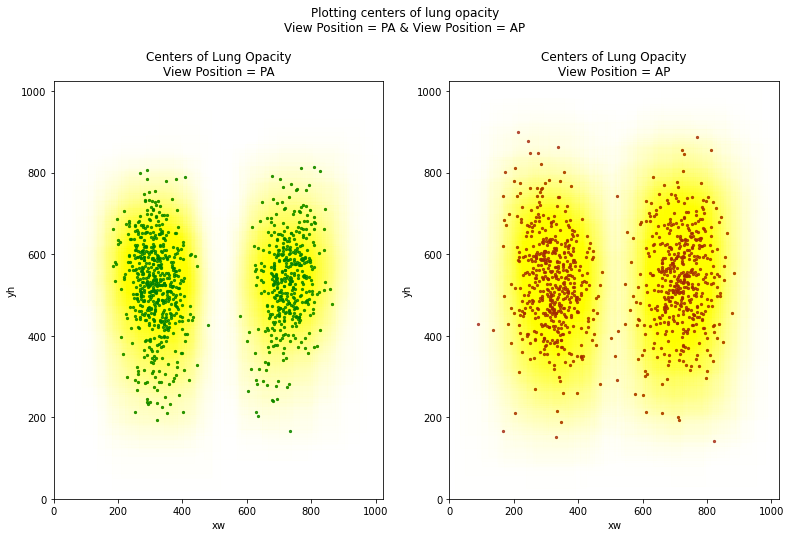

In [35]:
df1 = bboxes[bboxes['ViewPosition'] == 'PA'].sample(1000)
df2 = bboxes[bboxes['ViewPosition'] == 'AP'].sample(1000)
bboxes_scatter(df1, df2, 'View Position = PA', 'View Position = AP')

#### Plotting DICOM Images

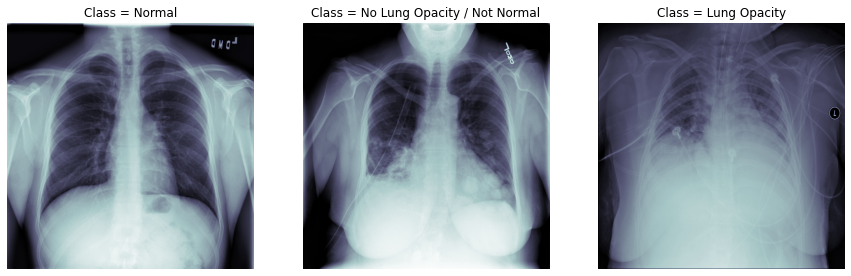

In [36]:
sample1 = train_class.loc[train_class['class'] == 'Normal'].iloc[0]
sample2 = train_class.loc[train_class['class'] == 'No Lung Opacity / Not Normal'].iloc[0]
sample3 = train_class.loc[train_class['class'] == 'Lung Opacity'].iloc[1]

ds1 = dcm.dcmread(sample1['path'])
ds2 = dcm.dcmread(sample2['path'])
ds3 = dcm.dcmread(sample3['path'])

f, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize = (15, 8))

ax1.imshow(ds1.pixel_array, cmap = plt.cm.bone)
ax1.set_title('Class = Normal')
ax1.axis('off')

ax2.imshow(ds2.pixel_array, cmap = plt.cm.bone)
ax2.set_title('Class = No Lung Opacity / Not Normal')
ax2.axis('off')

ax3.imshow(ds3.pixel_array, cmap = plt.cm.bone)
ax3.set_title('Class = Lung Opacity')
ax3.axis('off')

plt.show()

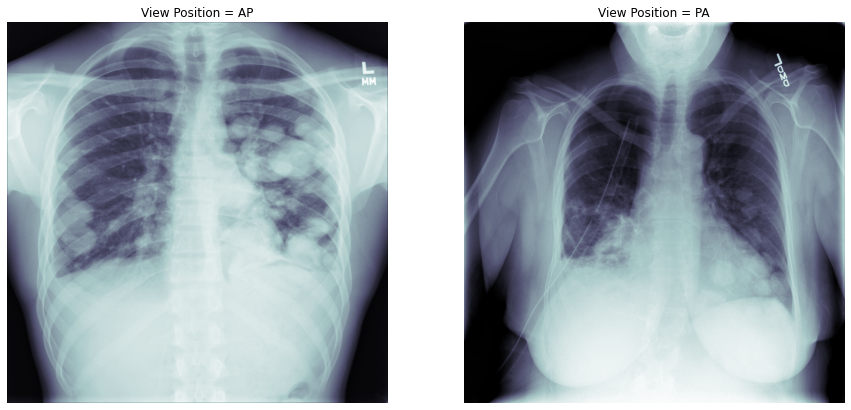

In [37]:
sample4 = train_class.loc[(train_class['ViewPosition'] == 'AP')].iloc[0]
sample5 = train_class.loc[(train_class['ViewPosition'] == 'PA')].iloc[0]

ds4 = dcm.dcmread(sample4['path'])
ds5 = dcm.dcmread(sample5['path'])

f, ((ax1, ax2)) = plt.subplots(1, 2, figsize = (15, 8))

ax1.imshow(ds4.pixel_array, cmap = plt.cm.bone)
ax1.set_title('View Position = AP')
ax1.axis('off')

ax2.imshow(ds5.pixel_array, cmap = plt.cm.bone)
ax2.set_title('View Position = PA')
ax2.axis('off')

plt.show()

In [38]:
def plot_dicom_images(data, df, img_path):
    img_data = list(data.T.to_dict().values())
    f, ax = plt.subplots(3, 3, figsize = (16, 18))
    for i, row in enumerate(img_data):
        image = row['patientId'] + '.dcm'
        path = os.path.join(img_path, image)
        data = dcm.read_file(path)
        rows = df[df['patientId'] == row['patientId']]
        age = rows.PatientAge.unique().tolist()[0]
        sex = data.PatientSex
        part = data.BodyPartExamined
        vp = data.ViewPosition
        modality = data.Modality
        data_img = dcm.dcmread(path)
        ax[i//3, i%3].imshow(data_img.pixel_array, cmap = plt.cm.bone)
        ax[i//3, i%3].axis('off')
        ax[i//3, i%3].set_title('ID: {}\nAge: {}, Sex: {}, Part: {}, VP: {}, Modality: {}\nTarget: {}, Class: {}\nWindow: {}:{}:{}:{}'\
                              .format(row['patientId'], age, sex, part, 
                                      vp, modality, row['Target'], 
                                      row['class'], row['x'], 
                                      row['y'], row['width'],
                                      row['height']))
        box_data = list(rows.T.to_dict().values())
        for j, row in enumerate(box_data):
            ax[i//3, i%3].add_patch(Rectangle(xy = (row['x'], row['y']),
                      width = row['width'], height = row['height'], 
                      color = 'red', alpha = 0.15)) 
    plt.show()

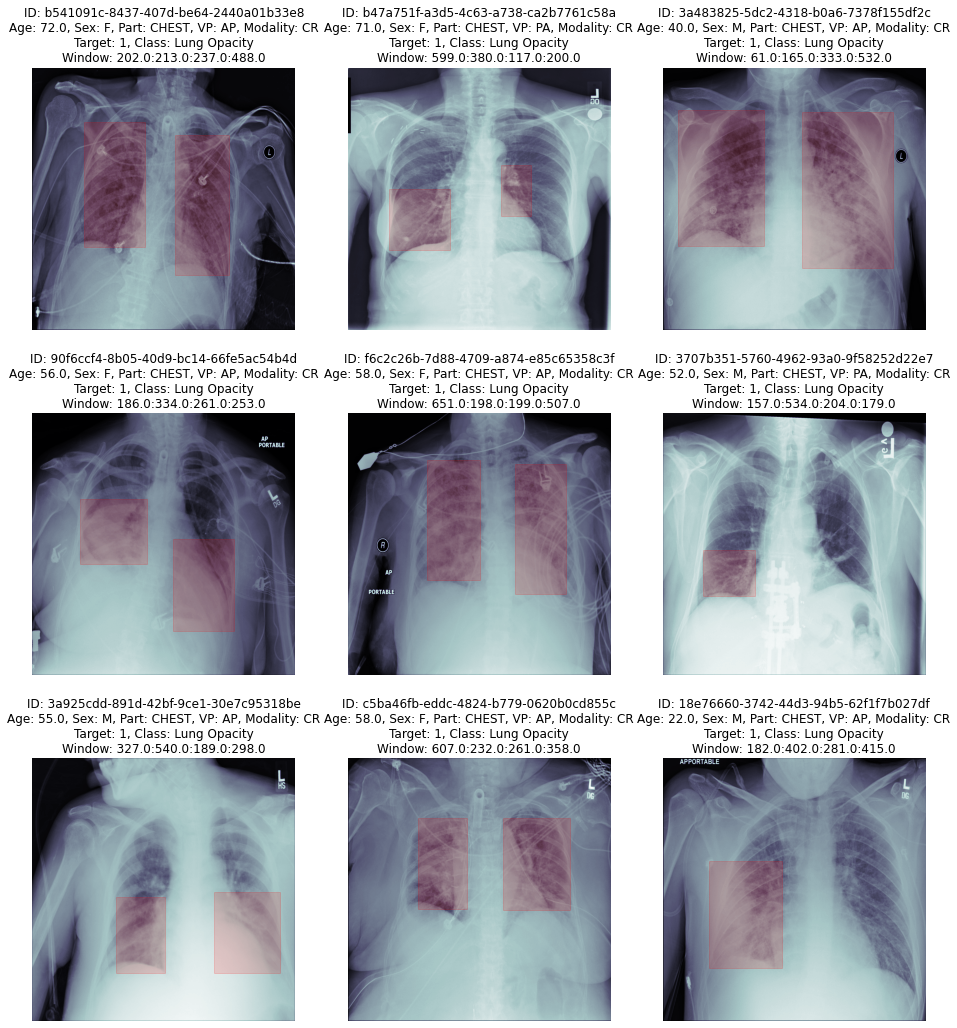

In [39]:
plot_dicom_images(data = train_class.loc[(train_class['Target'] == 1)].sample(9), 
                  df = train_class, img_path = TRAIN_IMAGES)

#### Design, train and test basic CNN models for classification.

In [40]:
train_class.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30227 entries, 0 to 30226
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   patientId        30227 non-null  object 
 1   x                9555 non-null   float64
 2   y                9555 non-null   float64
 3   width            9555 non-null   float64
 4   height           9555 non-null   float64
 5   Target           30227 non-null  int64  
 6   number_of_boxes  30227 non-null  int64  
 7   class            30227 non-null  object 
 8   path             30227 non-null  object 
 9   PatientSex       30227 non-null  object 
 10  PatientAge       30227 non-null  float64
 11  ViewPosition     30227 non-null  object 
dtypes: float64(5), int64(2), object(5)
memory usage: 4.0+ MB


<AxesSubplot:>

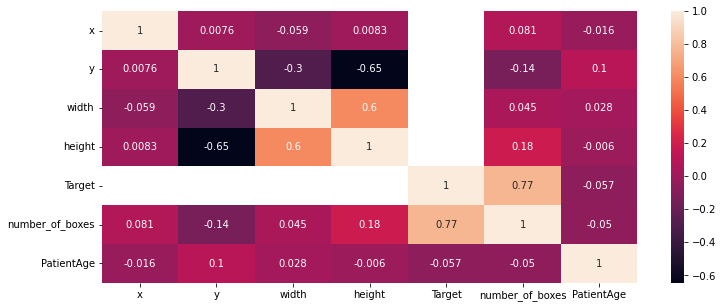

In [41]:
corr = train_class.corr()
plt.figure(figsize=(12,5))

sns.heatmap(corr,annot=True)

**Observation** -There is high correlation between Width and Height of bounding boxes.

In [42]:
## Considering 1000 samples from each class
sample = train_class.groupby('class', group_keys=False).apply(lambda x: x.sample(1000))

In [43]:
## Checking the training data set with class distribution 
sample["class"].value_counts()

Lung Opacity                    1000
No Lung Opacity / Not Normal    1000
Normal                          1000
Name: class, dtype: int64

In [44]:
## Pre Processing the image

IMAGES = []
ADJUSTED_IMAGE_SIZE = 128
imageList = []
classLabels = []
labels = []
originalImage = []

# Function to read the image from the path and reshape the image to size
def readandreshape(image):
    img = np.array(image).astype(np.uint8)
    ## Resize the image
    res = cv2.resize(img,(ADJUSTED_IMAGE_SIZE,ADJUSTED_IMAGE_SIZE), interpolation = cv2.INTER_LINEAR)
    return res

## Read the image and resize the image
def populateImage(rowdata):
    for index, row in rowdata.iterrows():
        patientId = row.patientId
        classlabel = row["class"]
        dcm_data = dcm.read_file(dcm_file)
        img = dcm_data.pixel_array
        
        ## Converting the image to 3 channels as the dicom image pixel does not have colour classes wiht it
        if len(img.shape) != 3 or img.shape[2] != 3:
            img = np.stack((img,) * 3, -1)
        imageList.append(readandreshape(img))
#         originalImage.append(img)
        classLabels.append(classlabel)
    tmpImages = np.array(imageList)
    tmpLabels = np.array(classLabels)
#     originalImages = np.array(originalImage)
    return tmpImages,tmpLabels

In [45]:
## Converting the images into numpy array
IMAGES,labels = populateImage(sample)

In [46]:
print(IMAGES.shape)
print(labels.shape)

(3000, 128, 128, 3)
(3000,)


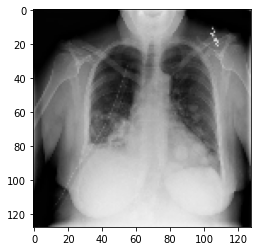

In [47]:
## Checking one of the converted image 
plt.imshow(IMAGES[555])

In [48]:
## Unique values
np.unique(labels)

array(['Lung Opacity', 'No Lung Opacity / Not Normal', 'Normal'],
      dtype='<U28')

In [49]:
# Creating a model considering input as 1024*1024 image
model = Sequential()

In [50]:
encode = LabelBinarizer()
y = encode.fit_transform(labels)

In [51]:
# splitting into train ,test and validation data
X_train, X_val, y_train, y_val = train_test_split(IMAGES, y, test_size=0.3, random_state=50)

In [52]:
# Function to create a dataframe for results
def outputresultDF(name,accuracy,testscore):
    result = pd.DataFrame({'Method':[name], 'accuracy': [accuracy] ,'Test Score':[testscore]})
    return result

**NOTE** - During model building,  we need to specify the following - 

- The **Accuracy function** is used to evaluate the performance of the model.

- The **Loss function** is used to measure how the model performs on data with known labels. It also tells us how poorly the model performs in a supervised system. For multi-label classification, specific loss function called as categorical_crossentropy is used.

- **Optimizer function** is used in order to minize the loss function by changing model parameters.

For this problem, we choose the **RMSprop optimizer** which is very efficient. 

In [53]:
# CNN Model without transfer learning

def cnn_model(height, width, num_channels, num_classes, loss='categorical_crossentropy', metrics=['accuracy']):
    batch_size = None

    model = Sequential()

    model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                  activation ='relu', batch_input_shape = (batch_size,height, width, num_channels)))


    model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))


    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'same', activation ='relu'))
    
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', activation ='relu'))
    model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', activation ='relu'))
    
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    
    model.add(Dropout(0.4))



    model.add(GlobalMaxPooling2D())
    model.add(Dense(256, activation = "relu"))
    model.add(Dropout(0.5))
    
    model.add(Dense(num_classes, activation = "softmax"))

    #optimiser 
    optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
    
    model.compile(optimizer = optimizer, loss = loss, metrics = metrics)
    model.summary()
    return model

In [54]:
# Model Summary
cnn = cnn_model(128,128,3,3)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 64, 64, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 64)        36928     
                                                      

In [55]:
## Training for 5 epochs with batch size of 30
history = cnn.fit(X_train, 
                  y_train, 
                  epochs = 5, 
                  validation_data = (X_val,y_val),
                  batch_size = 30)

Epoch 1/5
70/70 [==============================] - 108s 2s/step - loss: 3.4019 - accuracy: 0.3410 - val_loss: 1.0993 - val_accuracy: 0.3133
Epoch 2/5
70/70 [==============================] - 103s 1s/step - loss: 1.1351 - accuracy: 0.3290 - val_loss: 1.0992 - val_accuracy: 0.3133
Epoch 3/5
70/70 [==============================] - 105s 2s/step - loss: 1.1152 - accuracy: 0.3195 - val_loss: 1.0987 - val_accuracy: 0.3456
Epoch 4/5
70/70 [==============================] - 106s 2s/step - loss: 1.1059 - accuracy: 0.3305 - val_loss: 1.0990 - val_accuracy: 0.3133
Epoch 5/5
70/70 [==============================] - 106s 2s/step - loss: 1.1022 - accuracy: 0.3343 - val_loss: 1.1009 - val_accuracy: 0.3133


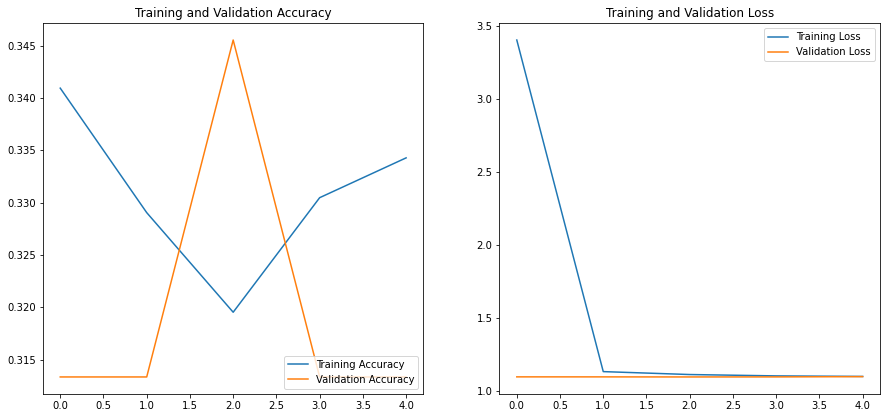

In [56]:
## PLottting the accuracy vs loss graph
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(5)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Observation** - 
- For the training and validation accuracy chart, Validation accuracy remains constant, this could be due to less number of images(3000) used in the modeling or due to less number of epochs.

- The training loss and validation loss is almost same 

#### Milestone 2:

#### Fine tuning the Basic CNN model

##### 1. Now we hypertune the parameters in order to do basic CNN model tuning

1. **Using Adam optimiser**
2. Experimenting with **batch size**
3. Changing the **learning rate**

##### The Learning rate(LR) is basically the step by which the optimizer is 'walking'. 

A **high LR** correspond to big steps and thus the convergence is faster. However, in that case the sampling is not really efficient since the optimizer do not fall especially in the right minima.

At the opposite, have a **low LR** means that the optimizer will probably find the right local minima but it will take a lot of time. 

In [57]:
# 1. CNN Model with Adam optimiser

def cnn_2(height, width, num_channels, num_classes, loss='categorical_crossentropy', metrics=['accuracy']):
    batch_size = None

    model = Sequential()

    model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                  activation ='relu', batch_input_shape = (batch_size,height, width, num_channels)))


    model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))


    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'same', activation ='relu'))
    
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', activation ='relu'))
    model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', activation ='relu'))
    
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    
    model.add(Dropout(0.4))
    model.add(GlobalMaxPooling2D())
    model.add(Dense(256, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation = "softmax"))
    #optimiser 
    optimizer2 = Adam(lr=0.001, epsilon=1e-08, decay=0.0)
    
    model.compile(optimizer = optimizer2, loss = loss, metrics = metrics)
    model.summary()
    return model

In [58]:
# Model Summary
cnn_adam= cnn_2(128,128,3,3)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 128, 128, 32)      2432      
                                                                 
 conv2d_7 (Conv2D)           (None, 128, 128, 32)      25632     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 64, 64, 32)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 conv2d_9 (Conv2D)           (None, 64, 64, 64)        36928     
                                                      

In [59]:
## Training for 5 epochs with batch size of 50
history_adam = cnn_adam.fit(X_train, 
                  y_train, 
                  epochs = 5, 
                  validation_data = (X_val,y_val),
                  batch_size = 50)

Epoch 1/5
42/42 [==============================] - 108s 3s/step - loss: 7.8553 - accuracy: 0.3352 - val_loss: 1.0988 - val_accuracy: 0.3133
Epoch 2/5
42/42 [==============================] - 107s 3s/step - loss: 1.1033 - accuracy: 0.3371 - val_loss: 1.0983 - val_accuracy: 0.3411
Epoch 3/5
42/42 [==============================] - 109s 3s/step - loss: 1.1036 - accuracy: 0.3324 - val_loss: 1.0987 - val_accuracy: 0.3411
Epoch 4/5
42/42 [==============================] - 109s 3s/step - loss: 1.1010 - accuracy: 0.3243 - val_loss: 1.0984 - val_accuracy: 0.3411
Epoch 5/5
42/42 [==============================] - 141s 3s/step - loss: 1.1005 - accuracy: 0.3152 - val_loss: 1.0989 - val_accuracy: 0.3133


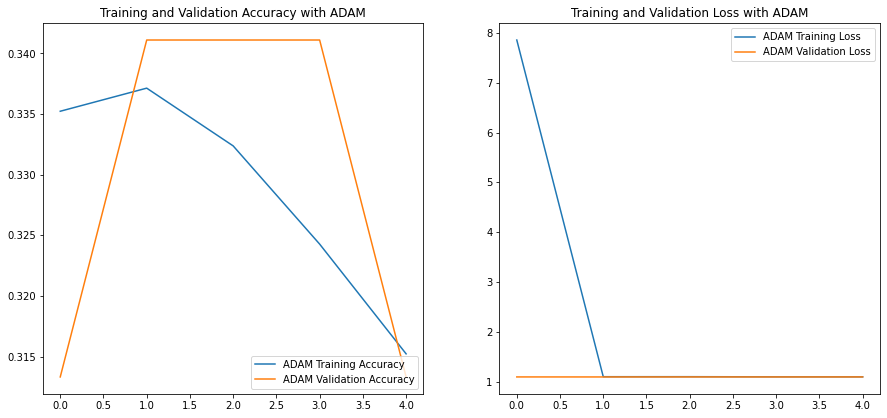

In [60]:
## Plottting the accuracy vs loss graph for ADAM optimiser

accuracy = history_adam.history['accuracy']
val_accuracy = history_adam.history['val_accuracy']
loss = history_adam.history['loss']
val_loss = history_adam.history['val_loss']
epochs_range = range(5)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, accuracy, label='ADAM Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='ADAM Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy with ADAM')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='ADAM Training Loss')
plt.plot(epochs_range, val_loss, label='ADAM Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss with ADAM')
plt.show()

In [61]:
## Training for 5 epochs with batch size of 100
history_batchsize = cnn_adam.fit(X_train, 
                  y_train, 
                  epochs = 5, 
                  validation_data = (X_val,y_val),
                  batch_size = 100)

Epoch 1/5
21/21 [==============================] - 143s 7s/step - loss: 1.0990 - accuracy: 0.3329 - val_loss: 1.0987 - val_accuracy: 0.3411
Epoch 2/5
21/21 [==============================] - 141s 7s/step - loss: 1.0989 - accuracy: 0.3438 - val_loss: 1.0988 - val_accuracy: 0.3411
Epoch 3/5
21/21 [==============================] - 138s 7s/step - loss: 1.0995 - accuracy: 0.3324 - val_loss: 1.0988 - val_accuracy: 0.3133
Epoch 4/5
21/21 [==============================] - 141s 7s/step - loss: 1.0989 - accuracy: 0.3395 - val_loss: 1.0986 - val_accuracy: 0.3411
Epoch 5/5
21/21 [==============================] - 142s 7s/step - loss: 1.0996 - accuracy: 0.3295 - val_loss: 1.0987 - val_accuracy: 0.3411


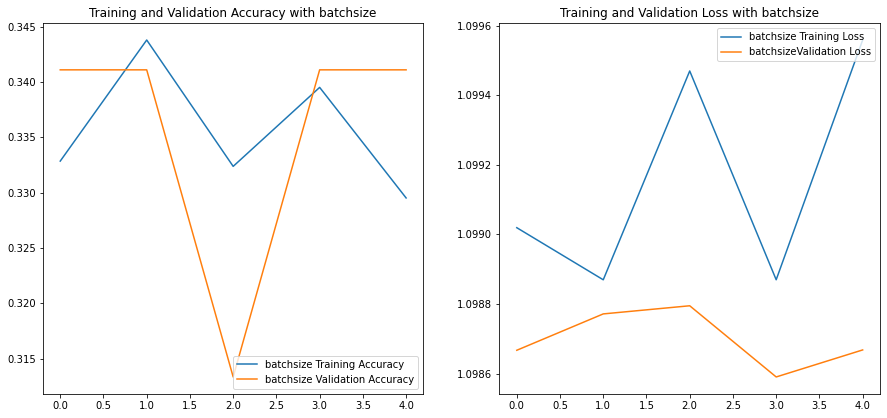

In [62]:
## Plottting the accuracy vs loss graph for Batch Size 100

accuracy = history_batchsize.history['accuracy']
val_accuracy = history_batchsize.history['val_accuracy']
loss = history_batchsize.history['loss']
val_loss = history_batchsize.history['val_loss']
epochs_range = range(5)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, accuracy, label='batchsize Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='batchsize Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy with batchsize')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='batchsize Training Loss')
plt.plot(epochs_range, val_loss, label='batchsizeValidation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss with batchsize')
plt.show()

#### Now we Use different Learning rate for CNN model 

In [63]:
# 2. CNN Model with different learning rate

def cnn_Learnrate(height, width, num_channels, num_classes, loss='categorical_crossentropy', metrics=['accuracy']):
    batch_size = None

    model = Sequential()

    model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                  activation ='relu', batch_input_shape = (batch_size,height, width, num_channels)))


    model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))


    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'same', activation ='relu'))
    
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', activation ='relu'))
    model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', activation ='relu'))
    
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    
    model.add(Dropout(0.4))



    model.add(GlobalMaxPooling2D())
    model.add(Dense(256, activation = "relu"))
    model.add(Dropout(0.5))
    
    model.add(Dense(num_classes, activation = "softmax"))

    #optimiser 
    optimizer = RMSprop(lr=0.006, rho=0.9, epsilon=1e-08, decay=0.0) # Using 0.006 LR
    
    model.compile(optimizer = optimizer, loss = loss, metrics = metrics)
    model.summary()
    return model

In [64]:
# Model Summary
cnn_lr= cnn_2(128,128,3,3)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 128, 128, 32)      2432      
                                                                 
 conv2d_13 (Conv2D)          (None, 128, 128, 32)      25632     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 64, 64, 32)        0         
                                                                 
 conv2d_14 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 conv2d_15 (Conv2D)          (None, 64, 64, 64)        36928     
                                                      

In [65]:
## Training for 5 epochs with batch size of 50
history_lr = cnn_lr.fit(X_train, 
                  y_train, 
                  epochs = 5, 
                  validation_data = (X_val,y_val),
                  batch_size = 50)

Epoch 1/5
42/42 [==============================] - 153s 4s/step - loss: 2.4619 - accuracy: 0.3267 - val_loss: 1.0978 - val_accuracy: 0.3456
Epoch 2/5
42/42 [==============================] - 141s 3s/step - loss: 1.1061 - accuracy: 0.3086 - val_loss: 1.0989 - val_accuracy: 0.3133
Epoch 3/5
42/42 [==============================] - 138s 3s/step - loss: 1.1007 - accuracy: 0.3348 - val_loss: 1.0992 - val_accuracy: 0.3133
Epoch 4/5
42/42 [==============================] - 138s 3s/step - loss: 1.0999 - accuracy: 0.3486 - val_loss: 1.0991 - val_accuracy: 0.3133
Epoch 5/5
42/42 [==============================] - 139s 3s/step - loss: 1.1019 - accuracy: 0.3257 - val_loss: 1.0993 - val_accuracy: 0.3133


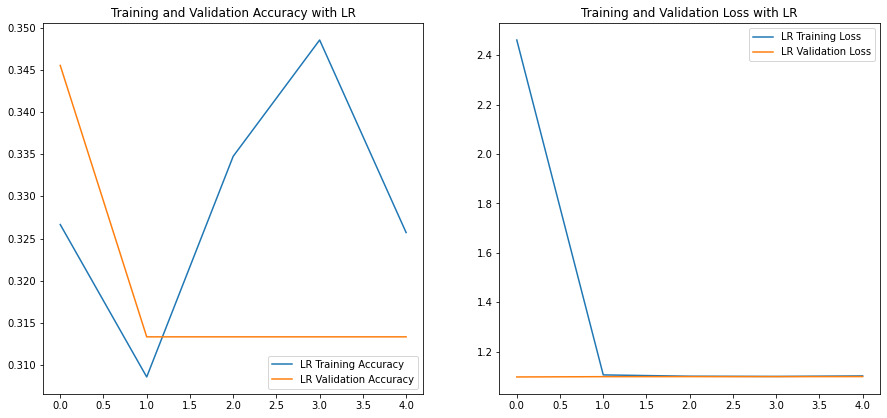

In [66]:
## PLottting the accuracy vs loss graph for Learning rate

accuracy = history_lr.history['accuracy']
val_accuracy = history_lr.history['val_accuracy']
loss = history_lr.history['loss']
val_loss = history_lr.history['val_loss']
epochs_range = range(5)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, accuracy, label='LR Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='LR Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy with LR')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='LR Training Loss')
plt.plot(epochs_range, val_loss, label='LR Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss with LR')
plt.show()

#### Conclusion:

After hypertuning the parameters, these are the findings:
1. With ADAM optimiser, there is no significant increase in validation accuracy, it is 0.3133
2. While changing the number of batches, Validation accuracy remains at 0.3133
3. Increasing the learning rate, there is no significant improvememnt in the accuracy. 

This maybe due to the imbalanced dataset and less number of epochs used. 
Due to constraints in our system.

**2. As a part of Fine tuning the basic CNN Model, we have just tried Resnet50 without applying any trasfer learning method (mentioned below).**

**Later, we have applied transfer learning method using U-Net.**

a) UNet with MobileNet

b) UNet with ResNet50

c) ResNet50

**After making the interim submission, there are two challenges:** 
- ***First:*** To write a function that can load the entire dataset at once.
- ***Second:*** Model Selection. Model selection is a challenge as both localization and classification are needed to be clubbed into one.

#### Function to load metadata from images

In [3]:
class image_metadata():
    '''
    Arguments:
        setName = name of the dataset
        file = filename
    '''
    
    def __init__(self, setName, file):
        self.setName = setName
        self.file = file
    
    def __repr__(self):
        #a special method used to represent a class's objects as a string
        return self.imagePath()
    
    def imagePath(self):
        return os.path.join(self.setName, self.file)

In [4]:
#function to load image metadata
def loadimagemetadata(dataSetName):
    '''
    Arguments:
        dataSetName = path of the data set folder
    '''
    
    imageMetadata = []
    for f in os.listdir(dataSetName):
        ext = os.path.splitext(f)[1]
        if ext == '.dcm':
            imageMetadata.append(image_metadata(dataSetName, f))
    return np.array(imageMetadata)

In [5]:
#function to load image and patientId
def loadImage(path):
    '''
    Arguments:
        path = path of the image
    '''
    
    img = dcm.dcmread(path)
    return img

def getImgId(imgPath):
    '''
    Arguments:
        imgPath = path of the image
    '''
    
    return str(imgPath).split('.dcm')[0].split('/')[6]

In [6]:
trainingSetImageMetadata = loadimagemetadata(TRAIN_IMAGES)

print('Size of train images: ', trainingSetImageMetadata.shape)
print()
print('Sample of train imagepath: ', trainingSetImageMetadata[0])

Size of train images:  (26684,)

Sample of train imagepath:  C:/Users/JAYANT/Downloads/Capstone/stage_2_train_images/0004cfab-14fd-4e49-80ba-63a80b6bddd6.dcm


#### Sample train image

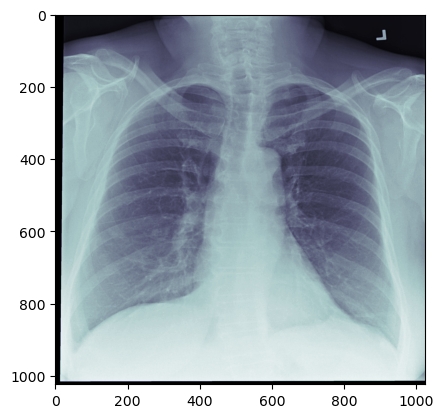

In [7]:
imgIndex = 10
imgPath = trainingSetImageMetadata[imgIndex]
imgPath = imgPath.imagePath()
imgData = loadImage(imgPath)

pyplot.imshow(imgData.pixel_array, cmap = pyplot.cm.bone)

#### Working dataframe

In [8]:
trainSetImageMetadata_df = pd.DataFrame(trainingSetImageMetadata, columns = ['Path'])

imageIdpaths = pd.DataFrame(columns = ['patientId', 'imgPath'])
imageIdpaths['patientId'] = trainSetImageMetadata_df['Path'].apply(getImgId)
imageIdpaths['imgPath'] = trainSetImageMetadata_df['Path']

print('Shape of the working dataframe: ', imageIdpaths.shape)
print()
print('The working dataframe looks like:\n')
imageIdpaths.head()

Shape of the working dataframe:  (26684, 2)

The working dataframe looks like:



patientId  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6   
1  000924cf-0f8d-42bd-9158-1af53881a557   
2  000db696-cf54-4385-b10b-6b16fbb3f985   
3  000fe35a-2649-43d4-b027-e67796d412e0   
4  001031d9-f904-4a23-b3e5-2c088acd19c6   

                                             imgPath  
0  C:/Users/JAYANT/Downloads/Capstone/stage_2_tra...  
1  C:/Users/JAYANT/Downloads/Capstone/stage_2_tra...  
2  C:/Users/JAYANT/Downloads/Capstone/stage_2_tra...  
3  C:/Users/JAYANT/Downloads/Capstone/stage_2_tra...  
4  C:/Users/JAYANT/Downloads/Capstone/stage_2_tra...

#### Reading CSV Files

In [9]:
class_info = pd.read_csv('C:/Users/JAYANT/Downloads/Capstone/stage_2_detailed_class_info.csv')
train_labels = pd.read_csv('C:/Users/JAYANT/Downloads/Capstone/stage_2_train_labels.csv')

In [10]:
print('The class_info dataframe has {} rows and {} columns and looks like:'.format(class_info.shape[0], class_info.shape[1]))
class_info.head()

The class_info dataframe has 30227 rows and 2 columns and looks like:


patientId                         class
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  No Lung Opacity / Not Normal
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd  No Lung Opacity / Not Normal
2  00322d4d-1c29-4943-afc9-b6754be640eb  No Lung Opacity / Not Normal
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5                        Normal
4  00436515-870c-4b36-a041-de91049b9ab4                  Lung Opacity

In [11]:
print('The train_labels dataframe has {} rows and {} columns and looks like:'.format(train_labels.shape[0], train_labels.shape[1]))
train_labels.head()

The train_labels dataframe has 30227 rows and 6 columns and looks like:


patientId      x      y  width  height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1

In [12]:
#sorting both the datasets based on patientId
class_info.sort_values('patientId', inplace = True)
train_labels.sort_values('patientId', inplace = True)

#merging both the data
train_class = pd.concat([train_labels, class_info['class']], axis = 1, sort = False)

print('The train_class dataframe has {} rows and {} columns and looks like:'.format(train_class.shape[0], train_class.shape[1]))
train_class.head()

The train_class dataframe has 30227 rows and 7 columns and looks like:


patientId      x      y  width  height  \
0      0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN   
28989  000924cf-0f8d-42bd-9158-1af53881a557    NaN    NaN    NaN     NaN   
28990  000db696-cf54-4385-b10b-6b16fbb3f985  316.0  318.0  170.0   478.0   
28991  000db696-cf54-4385-b10b-6b16fbb3f985  660.0  375.0  146.0   402.0   
28992  000fe35a-2649-43d4-b027-e67796d412e0  570.0  282.0  269.0   409.0   

       Target                         class  
0           0  No Lung Opacity / Not Normal  
28989       0                        Normal  
28990       1                  Lung Opacity  
28991       1                  Lung Opacity  
28992       1                  Lung Opacity

#### Convert the dataset into two classes only

In [13]:
train_class['class'].replace('No Lung Opacity / Not Normal', 'Normal', inplace = True)
print('The train_class dataframe with only two classes:')
train_class.head()

The train_class dataframe with only two classes:


patientId      x      y  width  height  \
0      0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN   
28989  000924cf-0f8d-42bd-9158-1af53881a557    NaN    NaN    NaN     NaN   
28990  000db696-cf54-4385-b10b-6b16fbb3f985  316.0  318.0  170.0   478.0   
28991  000db696-cf54-4385-b10b-6b16fbb3f985  660.0  375.0  146.0   402.0   
28992  000fe35a-2649-43d4-b027-e67796d412e0  570.0  282.0  269.0   409.0   

       Target         class  
0           0        Normal  
28989       0        Normal  
28990       1  Lung Opacity  
28991       1  Lung Opacity  
28992       1  Lung Opacity

Target 0 will correspond to Normal class whereas Target 1 will corresponds with Lung Opacity.

#### Splitting of the dataset into train, validation and test.

In [14]:
training_data = train_class[0:15000]
validation_data = train_class[15000:25000]
testing_data = train_class[25000:30227]

print('Shape of training data: ', training_data.shape)
print('Shape of validation data: ', validation_data.shape)
print('Shape of testing data: ', testing_data.shape)

Shape of training data:  (15000, 7)
Shape of validation data:  (10000, 7)
Shape of testing data:  (5227, 7)


#### Replace the NaN values present in the bounding box with 0

In [15]:
training_data.fillna(0, inplace = True)
validation_data.fillna(0, inplace = True)
testing_data.fillna(0, inplace = True)

#### Splitting of the dataset containing the image Paths into three: training, validation and testing.

In [16]:
print('Number of unique patientID in training data: ', training_data['patientId'].nunique())
print('Number of unique patientID in validation data: ', validation_data['patientId'].nunique())
print('Number of unique patientID in testing data: ', testing_data['patientId'].nunique())

Number of unique patientID in training data:  13163
Number of unique patientID in validation data:  8601
Number of unique patientID in testing data:  4920


In [17]:
imageIdpaths.sort_values('patientId', inplace = True)

train_imageIdpaths = imageIdpaths[0:13163]
validate_imageIdpaths = imageIdpaths[13163:21764]
test_imageIdpaths = imageIdpaths[21764:26684]

print('Shape of training dataframe having patientId and imagepaths: ', train_imageIdpaths.shape)
print('Shape of validation dataframe having patientId and imagepaths: ', validate_imageIdpaths.shape)
print('Shape of test dataframe having patientId and imagepaths: ', test_imageIdpaths.shape)

Shape of training dataframe having patientId and imagepaths:  (13163, 2)
Shape of validation dataframe having patientId and imagepaths:  (8601, 2)
Shape of test dataframe having patientId and imagepaths:  (4920, 2)


#### Functions that will help us in creating a model.

a) **Jaccard Loss Function**.

In [18]:
def iou_loss(y_true, y_pred):
    '''
    Arguments:
        y_true = actual mask 
        y_pred = predicted mask
    '''
    
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true * y_pred)
    score = (intersection + 1.) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection + 1.)
    return 1 - score

b) **Mean IOU** to measure the efficiency of the model (metric).

In [19]:
def mean_iou(y_true, y_pred):
    '''
    Arguments:
        y_true = actual mask
        y_pred = predicted mask
    '''
    
    y_pred = tf.round(y_pred)    
    intersect = tf.reduce_sum(y_true * y_pred, axis = [1]) 
    union = tf.reduce_sum(y_true, axis = [1]) + tf.reduce_sum(y_pred, axis = [1])
    smooth = tf.ones(tf.shape(intersect))
    return tf.reduce_mean((intersect + smooth) / (union - intersect + smooth))

c) Function to obtain **Intersection Over Union (IoU) ratio from Actual and Predicted Box Coordinates**

In [20]:
def iouFromCoords(boxA, boxB) :
    '''
    Arguments:
        boxA = actual mask
        boxB = predicted mask
    '''
    
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # compute the area of intersection rectangle
    intersectionArea = abs(max((xB - xA, 0)) * max((yB - yA), 0))
    if intersectionArea == 0:
        return 0
    
    # compute the area of both the prediction and ground-truth rectangles
    boxAArea = abs((boxA[2] - boxA[0]) * (boxA[3] - boxA[1]))
    boxBArea = abs((boxB[2] - boxB[0]) * (boxB[3] - boxB[1]))

    # compute the intersection over union
    iou = intersectionArea / float(boxAArea + boxBArea - intersectionArea)

    # return the intersection over union value
    return iou

d) Function to **display the image with an imposing mask**

In [21]:
def showMaskedImage(_imageSet, _maskSet, _index) :
    '''
    Arguments:
        _imageSet = set of images 
        _maskSet = set of masks
        _index = index of a set/collection
    '''
    
    maskImage = _imageSet[_index]

    maskImage[:,:,0] = _maskSet[_index] * _imageSet[_index][:,:,0]
    maskImage[:,:,1] = _maskSet[_index] * _imageSet[_index][:,:,1]
    maskImage[:,:,2] = _maskSet[_index] * _imageSet[_index][:,:,2]

    pyplot.imshow(maskImage[:,:,0], cmap=pyplot.cm.bone)

Some **basic variables** are defined

In [22]:
image_size = 224
img_width = 1024
img_height = 1024

train_batch_size = 10
test_batch_size = 10

- **class** is being defined to get data batch for training the model
- This class **UNetTrainGenerator** will help to load the training and validation data into the memory

**Data augmentation**- A useful trick to ovoid any overfitting is to use data augmentation. The idea is to add artificial data into our dataset. We alter the dataset with tiny transformations to reproduce very similar images.

For instance, we rotate of a few degree an image, we de-center it or we zoom in or out a little bit. These common augmentation techniques are horizontal/vertical flips, rotations, translations, rescaling, random crops, adjust brightness and more.

In [23]:
class UNetTrainGenerator(Sequence):
    '''
    Arguments:
        _imageIdpaths = dataframe having patientIds and imagepaths to load the image
        _mergedata = dataframe having patientId, bounding box coordinates, target and class
        idx = index of the batch
    '''
    
    def __init__(self, _imageIdPaths, _mergedata):
        self.pids = _mergedata['patientId'].to_numpy()
        self.imgIdPaths = _imageIdPaths
        self.coords = _mergedata[['x', 'y', 'width', 'height']].to_numpy()
        self.coords = self.coords * image_size / img_width
        
    def __len__(self):
        return math.ceil(len(self.coords) / train_batch_size)
    
    def __getitem__(self, idx):
        batch_coords = self.coords[idx * train_batch_size:(idx + 1) * train_batch_size] #image coords
        batch_pids = self.pids[idx * train_batch_size:(idx + 1) * train_batch_size] #image pids
        
        batch_images = np.zeros((len(batch_pids), image_size, image_size, 3), dtype = np.float32)
        batch_masks = np.zeros((len(batch_pids), image_size, image_size))
        
        for _indx, _pid in enumerate(batch_pids):
            _path = self.imgIdPaths[self.imgIdPaths['patientId'] == _pid]['imgPath'].array[0]
            _imgData = loadImage(str(_path))
            img = _imgData.pixel_array
            
            resized_image = cv2.resize(img, (image_size, image_size), interpolation = cv2.INTER_AREA)
            
            #preprocess image
            batch_images[_indx][:,:,0] = preprocess_input(np.array(resized_image[:,:], dtype = np.float32))
            batch_images[_indx][:,:,1] = preprocess_input(np.array(resized_image[:,:], dtype = np.float32))
            batch_images[_indx][:,:,2] = preprocess_input(np.array(resized_image[:,:], dtype = np.float32))
            
            x = int(batch_coords[_indx, 0])
            y = int(batch_coords[_indx, 1])
            width = int(batch_coords[_indx, 2]) 
            height = int(batch_coords[_indx, 3])
            
            batch_masks[_indx][y:y+height, x:x+height] = 1
        
        return batch_images, batch_masks

- **class** is being defined to get data batch for testing
- This class **UNetTestGenerator** will help to load the test data.

In [24]:
class UNetTestGenerator(Sequence):
    '''        
    Arguments:
        _imageIdPaths = dataframe having patientId and image paths to load image
        _mergedata = dataframe having patientId, bounding box coordinates, target and class      
        idx = index of a batch
    '''
    
    def __init__(self, _imageIdPaths, _mergedata):       
        self.pids = _mergedata['patientId'].to_numpy()
        self.imgIdPaths = _imageIdPaths
        self.coords = _mergedata[['x', 'y', 'width', 'height', 'Target']].to_numpy()
        self.classes = _mergedata['class']
        # Resize Bounding box
        self.coordsOrig = self.coords
        self.coords = self.coords * image_size / img_width           

    def __len__(self):
        # Returns total number of batches
        return math.ceil(len(self.coords) / test_batch_size)
    
    def __getitem__(self, idx):
        batch_coords = self.coords[idx * test_batch_size:(idx + 1) * test_batch_size]
        batch_coordsOrig = self.coordsOrig[idx * test_batch_size:(idx + 1) * test_batch_size]
        batch_pids = self.pids[idx * test_batch_size:(idx + 1) * test_batch_size]    
        batch_classes = self.classes[idx * test_batch_size:(idx + 1) * test_batch_size]           
        
        batch_images = np.zeros((len(batch_pids), image_size, image_size, 3), dtype=np.float32)
        batch_masks = np.zeros((len(batch_pids), image_size, image_size))
        for _indx, _pid in enumerate(batch_pids):
            _path = self.imgIdPaths[self.imgIdPaths['patientId'] == _pid]['imgPath'].array[0]
            _imgData = loadImage(str(_path))
            img = _imgData.pixel_array 
            
            # Resize image
            resized_img = cv2.resize(img, (image_size, image_size), interpolation=cv2.INTER_AREA)
            # preprocess image for the batch
            batch_images[_indx][:,:,0] = preprocess_input(np.array(resized_img[:,:], dtype=np.float32))
            batch_images[_indx][:,:,1] = preprocess_input(np.array(resized_img[:,:], dtype=np.float32))
            batch_images[_indx][:,:,2] = preprocess_input(np.array(resized_img[:,:], dtype=np.float32))  
            
            x = int(batch_coords[_indx, 0])
            y = int(batch_coords[_indx, 1])
            width = int(batch_coords[_indx, 2])
            height = int(batch_coords[_indx, 3])
            target = int(batch_coords[_indx, 4])
            
            batch_coords[_indx, 0] = x
            batch_coords[_indx, 1] = y 
            batch_coords[_indx, 2] = width 
            batch_coords[_indx, 3] = height    
            batch_coords[_indx, 4] = target 
            
            batch_masks[_indx][y:y+height, x:x+width] = 1
            
        # Returns images, ground truth masks, patientIds, resized-coordinates, class targets and ground truth coordinates/lables.   
        return batch_images, batch_masks, batch_pids, batch_coords, batch_classes, batch_coordsOrig

We found that **Transfer Learning(U-Net)** is widely used in medical applications. Hence we will try U-Net with 3 different model architectures.

a) UNet with MobileNet

b) UNet with ResNet50

c) ResNet50

#### Model Architecture

##### a) UNet with MobileNet

In [26]:
def create_UNetModel(trainable=True):
    '''        
    Arguments:
        trainable = Flag to make layers trainable. Default value is 'True'.
    '''
    # Get all layers with 'imagenet' weights
    model = MobileNet(input_shape = (image_size, image_size, 3), include_top=False,
                      alpha = 1.0, weights='imagenet') 
    # Top layer is last layer of the model
    
    # Make all layers trainable
    for layer in model.layers:
        layer.trainable = trainable

    # Add all the UNET layers here
    convLayer_112by112 = model.get_layer('conv_pw_1_relu').output
    convLayer_56by56 = model.get_layer('conv_pw_3_relu').output
    convLayer_28by28 = model.get_layer('conv_pw_5_relu').output
    convLayer_14by14 = model.get_layer('conv_pw_11_relu').output
    convLayer_7by7 = model.get_layer('conv_pw_13_relu').output
    # The last layer of mobilenet model is of dimensions (7x7x1024)
    # Steps to upsample from 7x7 to 14x14..upto 224x224 to form UNET
    x = Concatenate()([UpSampling2D()(convLayer_7by7), convLayer_14by14])
    x = Concatenate()([UpSampling2D()(x), convLayer_28by28])
    x = Concatenate()([UpSampling2D()(x), convLayer_56by56])
    x = Concatenate()([UpSampling2D()(x), convLayer_112by112])
    x = UpSampling2D(name='unet_last')(x) # upsample to 224x224

    # Add classification layer
    x = Conv2D(1, kernel_size=1, activation='sigmoid', name='masks')(x)
    x = Reshape((image_size, image_size))(x) 

    return Model(inputs=model.input, outputs=x)

##### b) UNet with ResNet50

In [27]:
def conv_block_simple(prevlayer, filters, prefix, strides=(1, 1)):
    '''       
    Arguments:
        prevlayer = previous layer of the convolution block
        filters = number of filters for convolution
        prefix = prefix for the layer name
        strides = convolution stride. Default is 1x1.
    '''
    conv = Conv2D(filters, (3, 3), padding='same', kernel_initializer='he_normal', strides=strides, name=prefix + '_conv')(prevlayer)
    conv = BatchNormalization(name=prefix + '_bn')(conv)
    conv = Activation('relu', name=prefix + '_activation')(conv)
    
    # Returns the built layers of the block.
    return conv

In [28]:
def create_ResNetUNetModel(trainable=True):
    '''        
    Arguments:
        trainable = Flag to make layers trainable. Default value is 'True'.
    '''
    resnetLayers = ResNet50(weights='imagenet', input_shape=(image_size, image_size, 3),
                            include_top=False) # Load pre-trained Resnet

    for layer in resnetLayers.layers:
        layer.trainable = trainable

    # Add all the UNet layers here
    convLayer_112by112 = resnetLayers.get_layer('conv1_relu').output
    convLayer_56by56 = resnetLayers.get_layer('conv2_block3_out').output
    convLayer_28by28 = resnetLayers.get_layer('conv3_block4_out').output
    convLayer_14by14 = resnetLayers.get_layer('conv4_block6_out').output
    convLayer_7by7 = resnetLayers.get_layer('conv5_block3_out').output
    # The last layer of resnet model(conv5_block3_out) is of dimensions (7x7x2048)
    
    # Start upsampling from 7x7 to 14x14 ...up to 224x224 to form UNet
    up14by14 = Concatenate()([UpSampling2D()(convLayer_7by7), convLayer_14by14])
    upConvLayer_14by14 = conv_block_simple(up14by14, 256, 'upConvLayer_14by14_1')
    upConvLayer_14by14 = conv_block_simple(upConvLayer_14by14, 256, 'upConvLayer_14by14_2')
    
    up28by28 = Concatenate()([UpSampling2D()(upConvLayer_14by14), convLayer_28by28])
    upConvLayer_28by28 = conv_block_simple(up28by28, 256, 'upConvLayer_28by28_1')
    upConvLayer_28by28 = conv_block_simple(upConvLayer_28by28, 256, 'upConvLayer_28by28_2')
     
    up56by56 = Concatenate()([UpSampling2D()(upConvLayer_28by28), convLayer_56by56])
    upConvLayer_56by56 = conv_block_simple(up56by56, 256, 'upConvLayer_56by56_1')
    upConvLayer_56by56 = conv_block_simple(upConvLayer_56by56, 256, 'upConvLayer_56by56_2')    
    
    up112by112 = Concatenate()([UpSampling2D()(upConvLayer_56by56), convLayer_112by112])
    upConvLayer_112by112 = conv_block_simple(up112by112, 256, 'upConvLayer_112by112_1')
    upConvLayer_112by112 = conv_block_simple(upConvLayer_112by112, 256, 'upConvLayer_112by112_2')   
    
    up224by224 = UpSampling2D(name='unet_last')(upConvLayer_112by112) # upsample to 224x224
    upConvLayer_224by224 = conv_block_simple(up224by224, 256, 'upConvLayer_224by224_1')
    upConvLayer_224by224 = conv_block_simple(upConvLayer_224by224, 256, 'upConvLayer_224by224_2')   

    # Add classification layer
    upConvLayer_224by224 = Conv2D(1, kernel_size=1, activation='sigmoid', name='masks')(upConvLayer_224by224)
    upConvLayer_224by224 = Reshape((image_size, image_size))(upConvLayer_224by224) 

    return Model(inputs=resnetLayers.input, outputs=upConvLayer_224by224)

##### c) ResNet50

In [29]:
model=ResNet50()
def ResNet_model():
    model = Sequential()
    model = ResNet50()
    for layer in model.layers[:-10]:
        layer.trainable = True


    block1 = model.get_layer('conv1_relu').output
    block2 = model.get_layer('conv2_block3_out').output
    block3 = model.get_layer('conv3_block4_out').output
    block4 = model.get_layer('conv4_block6_out').output
    block5 = model.get_layer('conv5_block3_out').output
  
  
    x = Concatenate()([UpSampling2D()(block5), block4])
    x = Conv2D(100, (1, 1), activation='relu') (x)
    x = Concatenate()([UpSampling2D()(x), block3])
    x = Conv2D(100, (1, 1), activation='relu') (x)
    x = Concatenate()([UpSampling2D()(x), block2])
    x = Conv2D(100, (1, 1), activation='relu') (x)
    x = Concatenate()([UpSampling2D()(x), block1])
    x = Conv2D(100, (1, 1), activation='relu') (x)
    x = UpSampling2D()(x)
    x = Conv2D(1, kernel_size=1,strides=1, activation='sigmoid')(x)
    x = Reshape((224, 224,1))(x)

    return Model(inputs=model.input, outputs=x)

#### Create Generator instances for Train and Validation datasets

In [30]:
trainUNet = UNetTrainGenerator(train_imageIdpaths, training_data)
validateUNet = UNetTrainGenerator(validate_imageIdpaths, validation_data)

#### Function to predict test data set and save the submission report into a csv file

In [31]:
def predictBatches(_test_mergedata, _test_imageIdpaths, _UNetModel) :
    """        
    Arguments:
        _test_mergedata: test set dataframe having patientId, bounding box coordinates, target and class
        _test_imageIdpaths: test set dataframe having patientId and image paths to load image        
        _UNetModel: UNet model with trainined weights used for predicting test data
    """
    
    print('Number of Test Samples:', _test_mergedata["patientId"].nunique())
    
    # create test generator instance
    testUNetDataGen = UNetTestGenerator(_test_imageIdpaths, _test_mergedata)
    
    # create submission dafa frame with column names
    submissionDF = pd.DataFrame(columns=['patientId', 'x', 'y', 'width', 'height', 'Target', 'class', 'x_pred', 'y_pred', 'width_pred', 
                                         'height_pred', 'predTarget', 'iou', 'class_pred'])
    dfIndex = 0
    iouThreshold = 0.3 # IoU above 30%

    # loop through testset
    # for batches from testUNetDataGen
    print("Predicting Batches ", end='')
    for batchImages, gtBatchMasks, batchPids, batchCoords, batchClasses, batchCoordsOrig in testUNetDataGen:
        
        # predict batch of images
        batchPreds = _UNetModel.predict(batchImages)
        
        prevPid = ""
        # loop through batch
        for pred, gtMask, pid, coords, gtClass, coordsOrig in zip(batchPreds, gtBatchMasks, batchPids, batchCoords, batchClasses, batchCoordsOrig):   #for (224, 224)

            if prevPid != pid :
                prevPid = pid

                # resize predicted mask
                pred = resize(pred, (1024, 1024), mode='reflect')   #for (1024, 1024)
                # recompute coords for resized pred
                coords = coordsOrig   #for (1024, 1024)

                # threshold predicted mask
                strongPred = pred[:, :] > 0.5   

                # apply connected components
                strongPred = measure.label(strongPred)
                
                loopIndx = 0
                # collect all reagions for the prediction
                iouCoordsDF = pd.DataFrame(columns=['iou', 'x', 'y', 'width', 'height'])
                for region in measure.regionprops(strongPred) :
                    # retrieve x, y, height and width
                    y, x, y2, x2 = region.bbox
                    height = y2 - y
                    width = x2 - x
                    # Get IOUs
                    coordsXYs = np.array([coords[0], coords[1], coords[2]+coords[0], coords[3]+coords[1]])
                    regionXYs = np.array([x, y, x2, y2])
                    IOU = iouFromCoords(coordsXYs, regionXYs)
                    iouCoordsRow = [IOU, x, y, width, height]
                    iouCoordsDF.loc[loopIndx] = iouCoordsRow
                    loopIndx = loopIndx + 1

                GTDFRow = [pid, coords[0], coords[1], coords[2], coords[3], coords[4], gtClass] # ground truth data 
                prevGTDFRow = []
                # Get top 2 predictions based on IOU 
                iouCoordsDF.sort_values("iou", ascending=False, inplace=True)
                predIOUCoordCount = 0
                # If predictions exist
                if len(iouCoordsDF) > 0 :
                    loopIndx = 0
                # collect all reagions for the prediction
                iouCoordsDF = pd.DataFrame(columns=['iou', 'x', 'y', 'width', 'height'])
                for region in measure.regionprops(strongPred) :
                    # retrieve x, y, height and width
                    y, x, y2, x2 = region.bbox
                    height = y2 - y
                    width = x2 - x
                    # Get IOUs
                    coordsXYs = np.array([coords[0], coords[1], coords[2]+coords[0], coords[3]+coords[1]])
                    regionXYs = np.array([x, y, x2, y2])
                    IOU = iouFromCoords(coordsXYs, regionXYs)
                    iouCoordsRow = [IOU, x, y, width, height]
                    iouCoordsDF.loc[loopIndx] = iouCoordsRow
                    loopIndx = loopIndx + 1

                GTDFRow = [pid, coords[0], coords[1], coords[2], coords[3], coords[4], gtClass] # ground truth data 
                prevGTDFRow = []
                # Get top 2 predictions based on IOU 
                iouCoordsDF.sort_values("iou", ascending=False, inplace=True)
                predIOUCoordCount = 0
                # If predictions exist
                if len(iouCoordsDF) > 0 :
                    for predIOUCoordIdx in (0, len(iouCoordsDF)-1) :
                        if iouCoordsDF.loc[predIOUCoordIdx]["iou"] > iouThreshold :
                            # add row with ground truth and prediction values to data frame    
                            submissionDFRow = [pid, coords[0], coords[1], coords[2], coords[3], coords[4],
                                               gtClass, int(iouCoordsDF.loc[predIOUCoordIdx]["x"]), int(iouCoordsDF.loc[predIOUCoordIdx]["y"]), 
                                               int(iouCoordsDF.loc[predIOUCoordIdx]["width"]), int(iouCoordsDF.loc[predIOUCoordIdx]["height"]), 
                                               1, iouCoordsDF.loc[predIOUCoordIdx]["iou"], "Lung Opacity"]
                            if predIOUCoordCount < 2 :
                                if GTDFRow != prevGTDFRow : 
                                    submissionDF.loc[dfIndex] = submissionDFRow
                                    dfIndex = dfIndex + 1 
                                    predIOUCoordCount = predIOUCoordCount + 1
                                    prevGTDFRow = GTDFRow
                            else :
                                break;
                        else : # Normal if IOU below threshold
                            # add row with ground truth and prediction values to data frame
                            if GTDFRow != prevGTDFRow :  
                                submissionDFRow = [pid, coords[0], coords[1], coords[2], coords[3], coords[4], 
                                                   gtClass, 0, 0, 0, 0, 0, iouCoordsDF.loc[predIOUCoordIdx]["iou"], "Normal"]
                                submissionDF.loc[dfIndex] = submissionDFRow
                                dfIndex = dfIndex + 1  
                                prevGTDFRow = GTDFRow
                                break;
                else : # else of If predictions exist. Normal if no predictions
                    # add row with ground truth and prediction values to data frame
                    submissionDFRow = [pid, coords[0], coords[1], coords[2], coords[3], coords[4], 
                                       gtClass, 0, 0, 0, 0, 0, 'NA', "Normal"]
                    submissionDF.loc[dfIndex] = submissionDFRow
                    dfIndex = dfIndex + 1      

    # save dictionary as csv file
    submissionDF.to_csv('submission.csv', index=False)
    print("Prediction Complete!")
    
    test_y = submissionDF["Target"]
    predicted_y = submissionDF["predTarget"]
    
    return test_y.apply(int), predicted_y.apply(int)

#### Function to create Confusion Matrix and Classification Report

In [32]:
def showConfusionMatrix(IOU_report) :
    '''   
    Arguments:
        IOU_report = dataframe having target and prediction columns.
    '''
    
    IOU_report.fillna(0, inplace=True)
    
    # Get Targets and Predictions
    y_IOU_test = IOU_report['Target']
    y_IOU_predicted = IOU_report['predTarget']
    print('Predictions in terms of IOU :\n')
    print('Confusion Matrix:\n', metrics.confusion_matrix(y_IOU_test, y_IOU_predicted))
    print('\nClassification Report:\n', metrics.classification_report(y_IOU_test, y_IOU_predicted))

#### Function to visualize predictions by displaying the ground truth and predicted bounding box

In [33]:
def visualizePredictions(_predReportDF, _topNum) :
    '''        
    Arguments:
        _predReportDF = dataframe having patientId, IoUs, target and prediction coordinate columns.
        _topNum = number indicating the count of top predictions to be visualized.
    '''
    # Sort on IOU to get higher IOUs on top
    _predReportDF.sort_values('iou', ascending=False, inplace=True)
    # Get patientIds
    topPids = _predReportDF['patientId'].head(_topNum)
    topPidsAry = np.array(topPids)
    # Get IOUs
    topIOUs = _predReportDF['iou'].head(_topNum)
    topIOUsAry = np.array(topIOUs)

    # To get ground truth images for top IOU scored pids
    imageCollc = np.zeros((_topNum, img_width, img_height), np.float32)

    # Get ground truth coordinates for top IOU scored rows and prepare masks
    gtCoordCollc = _predReportDF[['x', 'y', 'width', 'height']].to_numpy()
    # To get ground truth masks
    gtMaskCollc  = np.zeros((_topNum, img_width, img_height), np.int)

    # Get ground truth coordinates for top IOU scored rows and prepare masks
    predCoordCollc = _predReportDF[['x_pred', 'y_pred', 'width_pred', 'height_pred']].to_numpy()  # (1024, 1024)
    # To get ground truth masks
    predMaskCollc  = np.zeros((_topNum, img_width, img_height), np.int)
    
    # Get ground truth and prediction masks
    for indx in range(0, _topNum) :
        # Get images
        path = test_imageIdpaths[test_imageIdpaths['patientId'] == topPidsAry[indx]]['imgPath'].array[0]
        imgData = loadImage(str(path)) # Read image
        img = imgData.pixel_array
        imageCollc[indx][:,:] = preprocess_input(np.array(img[:,:], dtype=np.float32)) # Convert to float32 array

        # prepare ground truth masks
        x = int(gtCoordCollc[indx, 0])
        y = int(gtCoordCollc[indx, 1])
        width = int(gtCoordCollc[indx, 2])
        height = int(gtCoordCollc[indx, 3])
        gtMaskCollc[indx][y:y+height, x:x+width] = 1   # (1024, 1024)

        # prepare predicted masks
        x_pred = int(predCoordCollc[indx, 0])
        y_pred = int(predCoordCollc[indx, 1])
        width_pred = int(predCoordCollc[indx, 2])
        height_pred = int(predCoordCollc[indx, 3])
        predMaskCollc[indx][y_pred:y_pred+height_pred, x_pred:x_pred+width_pred] = 1   # (1024, 1024)
        
    # Show images and bounding boxes
    imageArea, axesArry = pyplot.subplots(int(_topNum/2), 2, figsize=(18,18))
    axesArry = axesArry.ravel()
    for axidx in range(0, _topNum) :
        axesArry[axidx].imshow(imageCollc[axidx][:, :], cmap=pyplot.cm.bone)

        gtComp = gtMaskCollc[axidx][:, :] > 0.5
        # apply connected components
        gtComp = measure.label(gtComp)
        # apply ground truth bounding boxes
        for region in measure.regionprops(gtComp):
            # retrieve x, y, height and width
            y1, x1, y2, x2 = region.bbox
            heightReg = y2 - y1
            widthReg = x2 - x1
            axesArry[axidx].add_patch(patches.Rectangle((x1, y1), widthReg, heightReg, linewidth=1, edgecolor='r', 
                                                        facecolor='none'))
            
        predComp = predMaskCollc[axidx][:, :] > 0.5
        # apply connected components
        predComp = measure.label(predComp)
        # apply predicted bounding boxes
        for region_pred in measure.regionprops(predComp):
            # retrieve x, y, height and width
            y1_pred, x1_pred, y2_pred, x2_pred = region_pred.bbox
            heightReg_pred = y2_pred - y1_pred
            widthReg_pred = x2_pred - x1_pred
            axesArry[axidx].add_patch(patches.Rectangle((x1_pred, y1_pred), widthReg_pred, heightReg_pred, linewidth=1, edgecolor='b', 
                                                        facecolor='none'))
            axesArry[axidx].set_title('IOU : '+str(topIOUsAry[axidx]))
    # Show subplots
    pyplot.show()

#### Function to plot the performance curves

In [34]:
def plotHistory(_HISTORY_FILE) :
    """        
    Arguments:
        _HISTORY_FILE: training history file name.
    """
    unetSavedHistory = np.load(_HISTORY_FILE, allow_pickle=True).item()
    unetSavedHistoryDF = pd.DataFrame(unetSavedHistory)
    
    #summarize history for loss
    pyplot.plot(unetSavedHistoryDF['loss'])
    pyplot.plot(unetSavedHistoryDF['val_loss'])
    pyplot.title('Model Loss')
    pyplot.ylabel('Loss')
    pyplot.xlabel('Epoch')
    pyplot.legend(['Train', 'Validation'], loc='best')
    pyplot.show()
    
    # summarize history for mean IOU
    pyplot.plot(unetSavedHistoryDF['mean_iou'])
    pyplot.plot(unetSavedHistoryDF['val_mean_iou'])
    pyplot.title('Model IOU')
    pyplot.ylabel('IOU')
    pyplot.xlabel('Epoch')
    pyplot.legend(['Train', 'Validation'], loc='best')
    pyplot.show()

#### Training model

##### a) UNet with MobileNet

In [35]:
UNet_MobileNet_Model = create_UNetModel()
print(UNet_MobileNet_Model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
__________________________________________________________________________________________________
conv1_relu (ReLU)               (None, 112, 112, 32) 0           conv1_bn[0][0]                   
______________________________________________________________________________________________

In [36]:
#optimizer
adamopt = Adam(lr = 1e-4, beta_1 = 0.9, beta_2 = 0.999, epsilon = None, decay = 0.0, amsgrad = False)
UNet_MobileNet_Model.compile(optimizer = adamopt, loss = iou_loss, metrics = [mean_iou])

In [37]:
def cosine_annealing(x):
    lr = 0.001
    epochs = 10
    return lr*(np.cos(np.pi * x/epochs) + 1.) / 2

learning_rate = LearningRateScheduler(cosine_annealing)
checkpoint = ModelCheckpoint("umobile-{epoch:02d}-{val_mean_iou:.2f}.h5", monitor = 'loss',
                             verbose = 1, mode = 'min', save_best_only = True,
                             save_weights_only = True)
stop = EarlyStopping(monitor = 'loss', mode = 'min', patience = 3)

In [38]:
history_umobile = UNet_MobileNet_Model.fit_generator(generator = trainUNet, epochs = 5,
                                                    validation_data = validateUNet,
                                                    callbacks = [learning_rate, checkpoint, stop],
                                                    shuffle = True, verbose = 1)

Epoch 1/5
1500/1500 [==============================] - 13568s 9s/step - loss: 0.8330 - mean_iou: 0.7692 - val_loss: 0.7491 - val_mean_iou: 0.7777

Epoch 00001: loss improved from inf to 0.83300, saving model to umobile-01-0.78.h5
Epoch 2/5
1500/1500 [==============================] - 11229s 7s/step - loss: 0.8039 - mean_iou: 0.7921 - val_loss: 0.7457 - val_mean_iou: 0.8368

Epoch 00002: loss improved from 0.83300 to 0.80393, saving model to umobile-02-0.84.h5
Epoch 3/5
1500/1500 [==============================] - 11184s 7s/step - loss: 0.7953 - mean_iou: 0.8045 - val_loss: 0.7666 - val_mean_iou: 0.8421

Epoch 00003: loss improved from 0.80393 to 0.79530, saving model to umobile-03-0.84.h5
Epoch 4/5
1500/1500 [==============================] - 11190s 7s/step - loss: 0.7881 - mean_iou: 0.8120 - val_loss: 0.7315 - val_mean_iou: 0.8064

Epoch 00004: loss improved from 0.79530 to 0.78812, saving model to umobile-04-0.81.h5
Epoch 5/5
1500/1500 [==============================] - 11185s 7s/ste

In [42]:
UNet_MobileNet_Model.load_weights('C:/Users/JAYANT/Downloads/umobile-05-0.84.h5')

##### Predicting on the test set

In [43]:
y_test, y_predicted = predictBatches(testing_data, test_imageIdpaths, UNet_MobileNet_Model)

Number of Test Samples: 4920
Predicting Batches Prediction Complete!


##### Confusion Matix

(Although csv file will be saved as submission.csv, we have renamed to submission 1.csv, submission 2.csv, submission 3.csv respectively for 3 models)

In [44]:
report_file_um = pd.read_csv('C:/Users/JAYANT/Downloads/submission 1.csv')
showConfusionMatrix(report_file_um)

Predictions in terms of IOU :

Confusion Matrix:
 [[4214    0]
 [ 623  117]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.87      1.00      0.93      4214
         1.0       1.00      0.16      0.27       740

    accuracy                           0.87      4954
   macro avg       0.94      0.58      0.60      4954
weighted avg       0.89      0.87      0.83      4954



- **Precision** is a fraction of people actually having pneumonia to all those predicted by the model as having pneumonia. 

- **Recall/Sensitivity** on the other hand refers to the fraction of people actually having pneumonia and are predicted positive by the model to the total number of people having pneumonia. Hence, it relates to the potential of a test to recognise subjects with the disease.

According to theory in medical diagnosis, having False Negatives can prove to be far more fatal than having False Positives. Since there is a trade-off between precision and recall , which means one increases at the cost of other , our main motive will be to have a high recall for our model and a relatively low but good precision as well.

**Observation from Confusion Matrix** -


**True Positives(TP)** - 117 cases. Thus, our model successfully prdicted the cases of Pneumonia pr cases with Lung Opacity

**True Negatives(TN)** - 4214 patients who have actually 'No Lung Opacity'/'Normal' are correctly predicted as 'Normal' or cases with no Pneumonia

**False Positives(FP)** - 0 cases who have actually 'No Lung Opacity'/'Normal' incorrectly predicted as having 'Lung Opacity'. **Type-I error is LESS** . This is a big positive point for a medical test

**False Negatives(FN)** are - 623 cases where the patients who have actually 'Lung Opacity' or 'Pneumonia' are incorrectly predicted as'Normal'. These are model mistakes.

##### Visualization of our Prediction

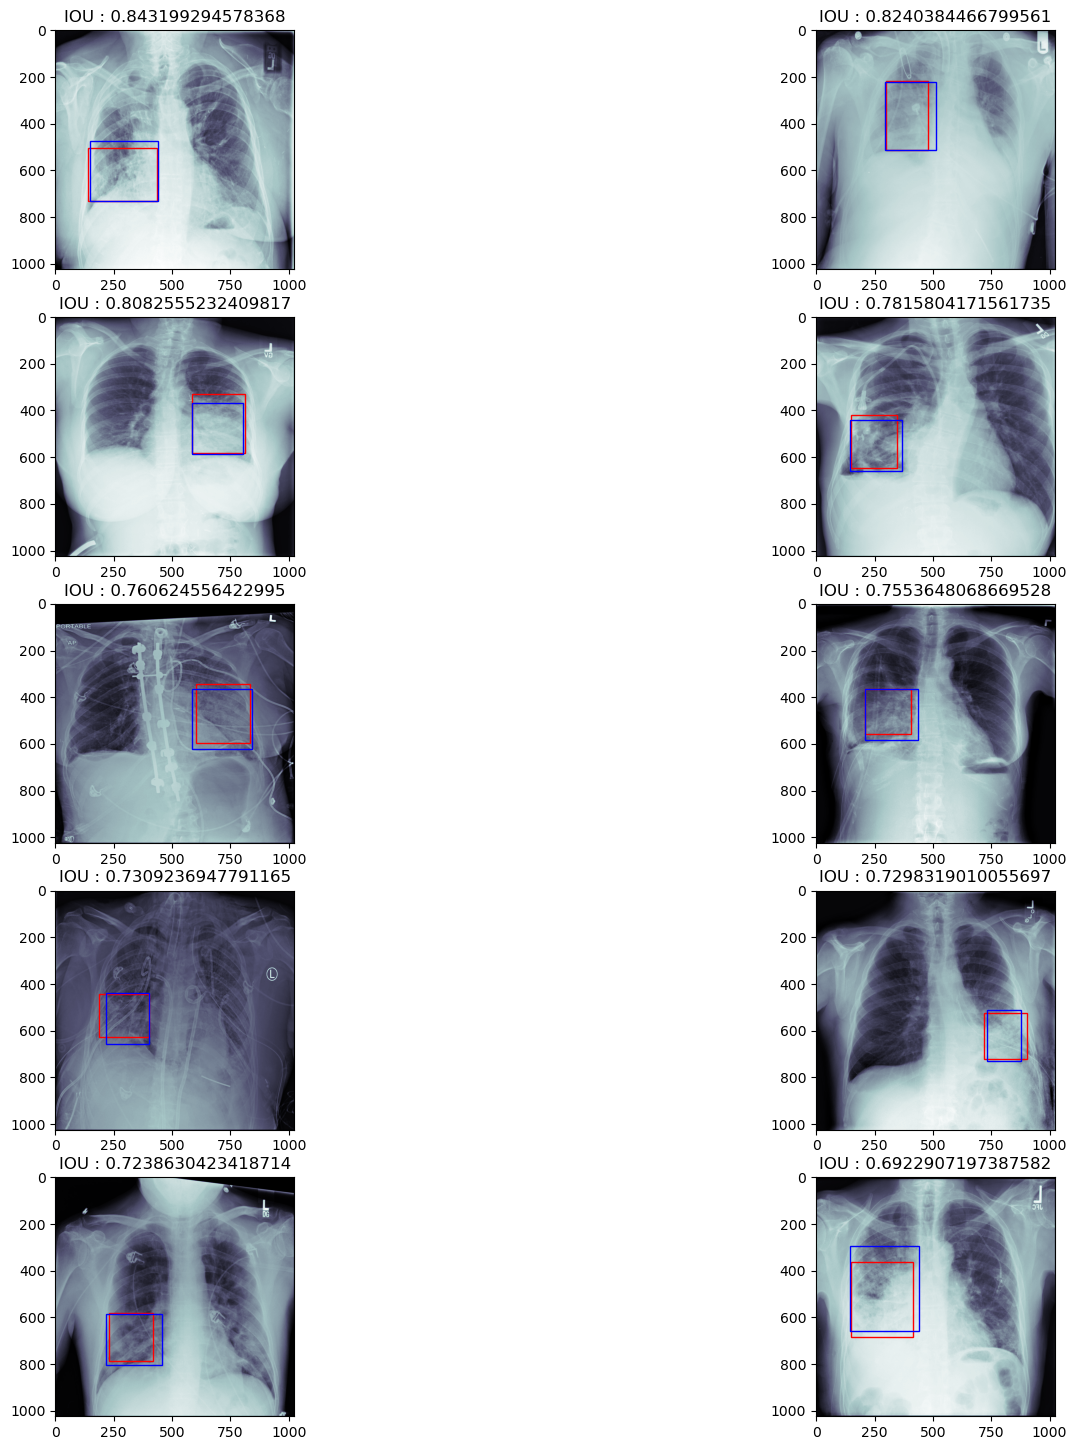

In [45]:
top = 10
visualizePredictions(report_file_um, top)

##### Plot the performance curves

In [46]:
umobhist = np.array(history_umobile.history)
np.save("History_UNM", umobhist, allow_pickle = True)

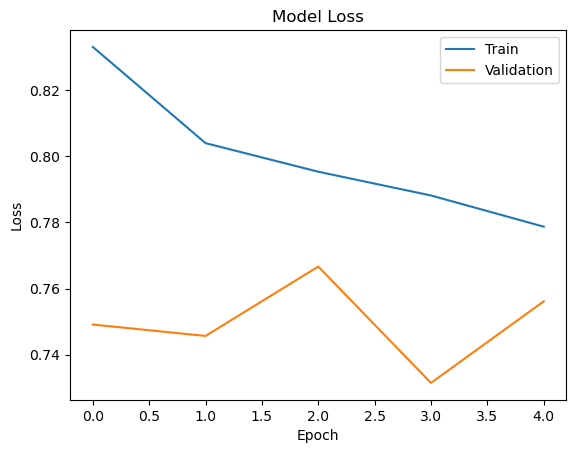

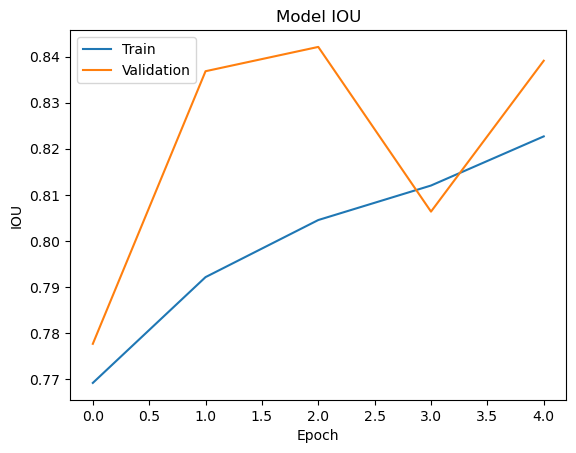

In [48]:
history_file = 'C:/Users/JAYANT/Downloads/History_UNM.npy'
plotHistory(history_file)

##### b) UNet with ResNet50

In [49]:
UNet_ResNet_Model = create_ResNetUNetModel()
print(UNet_ResNet_Model.summary())

94773248/94765736 [==============================] - 19s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
__________________________

In [50]:
#optimizer
adamopt_r = Adam(lr = 1e-1, beta_1 = 0.9, beta_2 = 0.999, epsilon = None, decay = 0.0, amsgrad = False)
UNet_ResNet_Model.compile(optimizer = adamopt_r, loss = iou_loss, metrics = [mean_iou])

In [51]:
def cosine_annealing(x):
    lr = 0.001
    epochs = 10
    return lr*(np.cos(np.pi * x/epochs) + 1.) / 2

learning_rate = LearningRateScheduler(cosine_annealing)
checkpoint = ModelCheckpoint("ures-{epoch:02d}-{val_mean_iou:.2f}.h5", monitor = 'loss',
                             verbose = 1, mode = 'min', save_best_only = True,
                             save_weights_only = True)
stop = EarlyStopping(monitor = 'loss', mode = 'min', patience = 3)

In [52]:
history_unres = UNet_ResNet_Model.fit_generator(generator = trainUNet, epochs = 5,
                                               validation_data = validateUNet,
                                               callbacks = [learning_rate, checkpoint, stop],
                                               shuffle = True, verbose = 1)

Epoch 1/5
1500/1500 [==============================] - 30351s 20s/step - loss: 0.8434 - mean_iou: 0.7496 - val_loss: 0.8295 - val_mean_iou: 0.6958

Epoch 00001: loss improved from inf to 0.84337, saving model to ures-01-0.70.h5
Epoch 2/5
1500/1500 [==============================] - 25471s 17s/step - loss: 0.8177 - mean_iou: 0.7815 - val_loss: 0.7784 - val_mean_iou: 0.7897

Epoch 00002: loss improved from 0.84337 to 0.81767, saving model to ures-02-0.79.h5
Epoch 3/5
1500/1500 [==============================] - 25427s 17s/step - loss: 0.8093 - mean_iou: 0.7869 - val_loss: 0.7694 - val_mean_iou: 0.8018

Epoch 00003: loss improved from 0.81767 to 0.80930, saving model to ures-03-0.80.h5
Epoch 4/5
1500/1500 [==============================] - 26443s 18s/step - loss: 0.8032 - mean_iou: 0.7972 - val_loss: 0.7597 - val_mean_iou: 0.8071

Epoch 00004: loss improved from 0.80930 to 0.80321, saving model to ures-04-0.81.h5
Epoch 5/5
1500/1500 [==============================] - 25548s 17s/step - los

In [53]:
UNet_ResNet_Model.load_weights('C:/Users/JAYANT/Downloads/ures-05-0.81.h5')

##### Predicting on the test set

In [54]:
y_test, y_predicted = predictBatches(testing_data, test_imageIdpaths, UNet_ResNet_Model)

Number of Test Samples: 4920
Predicting Batches Prediction Complete!


##### Confusion Matrix

In [55]:
report_file_ur = pd.read_csv('C:/Users/JAYANT/Downloads//submission_2.csv')
showConfusionMatrix(report_file_ur)

Predictions in terms of IOU :

Confusion Matrix:
 [[4214    0]
 [ 639  101]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.87      1.00      0.93      4214
         1.0       1.00      0.14      0.24       740

    accuracy                           0.87      4954
   macro avg       0.93      0.57      0.58      4954
weighted avg       0.89      0.87      0.83      4954



**Observation from Confusion Matrix** -


**True Positives(TP)** - 101 cases. Thus, our model successfully predicted the cases of Pneumonia pr cases with Lung Opacity

**True Negatives(TN)** - 4214 patients who have actually 'No Lung Opacity'/'Normal' are correctly predicted as 'Normal' or cases with no Pneumonia

**False Positives(FP)** - 0 cases who have actually 'No Lung Opacity'/'Normal' incorrectly predicted as having 'Lung Opacity'. **Type-I error is LESS** . This is a big positive point for a medical test

**False Negatives(FN)** are - 639 cases where the patients who have actually 'Lung Opacity' or 'Pneumonia' are incorrectly predicted as'Normal'. These are model mistakes.

##### Visualizing the Prediction

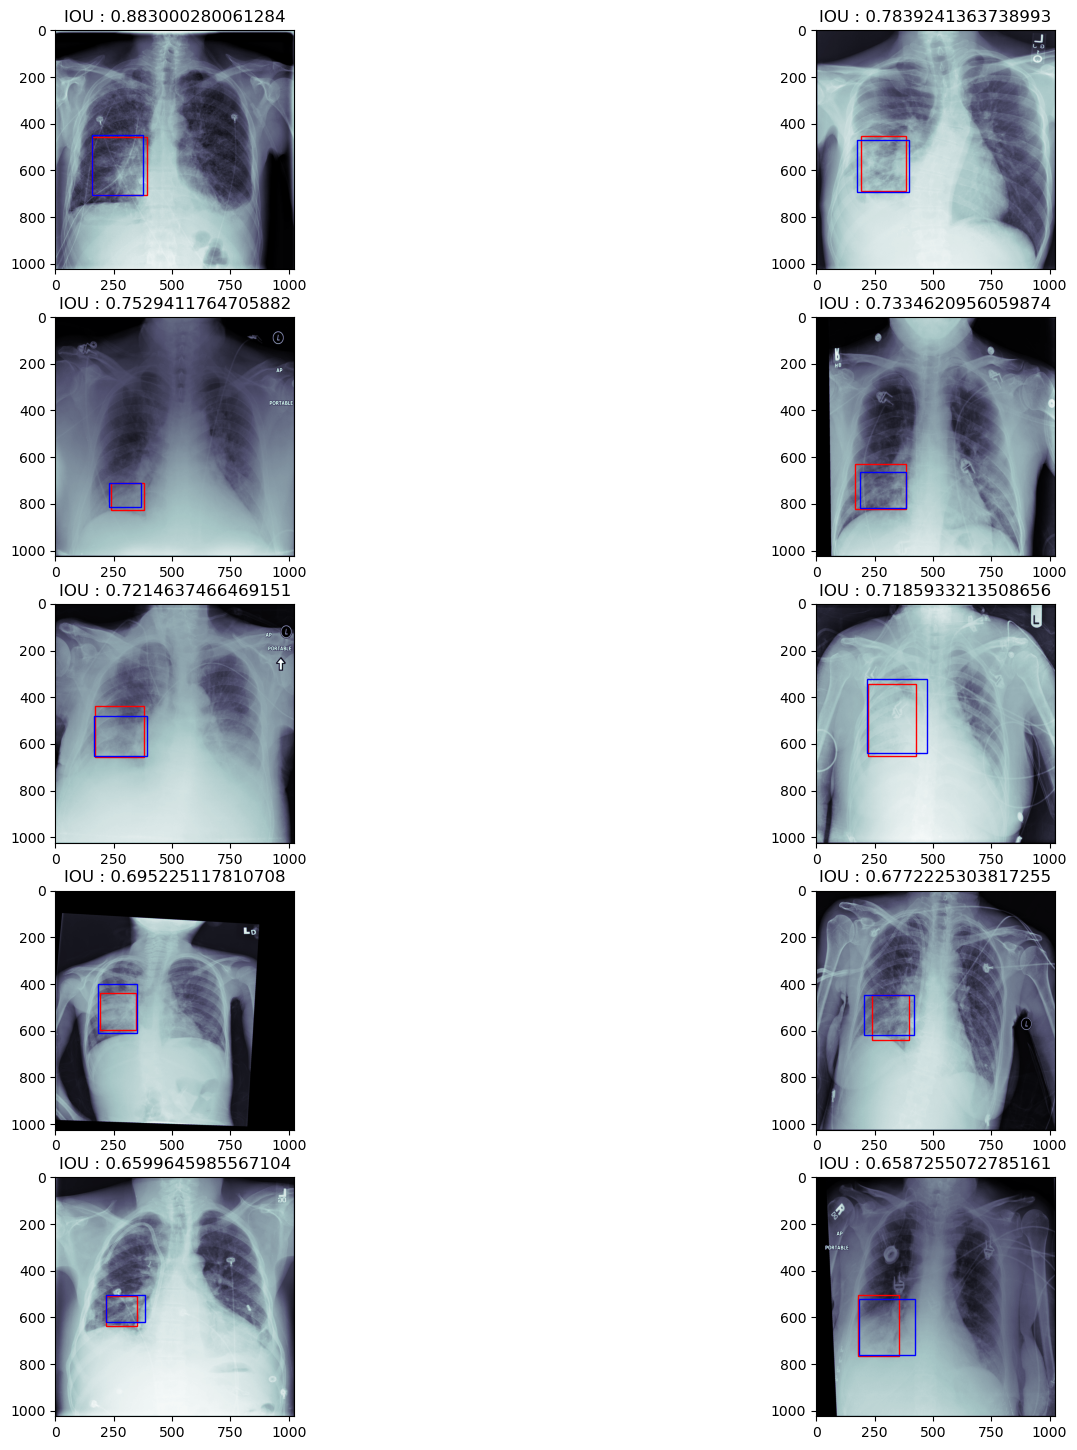

In [56]:
top = 10
visualizePredictions(report_file_ur, top)

##### Plot the performance curves

In [57]:
ureshist = np.array(history_unres.history)
np.save("History_UR", ureshist, allow_pickle = True)

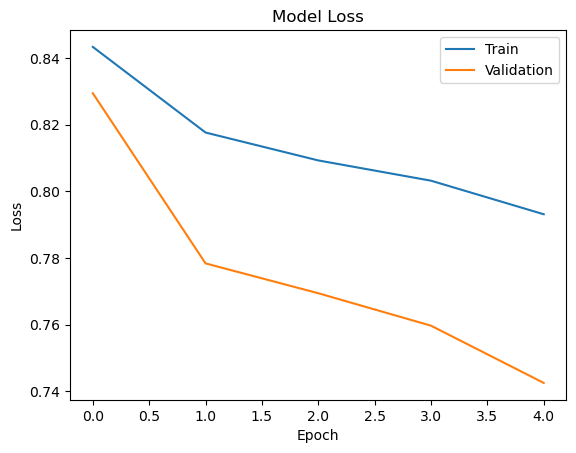

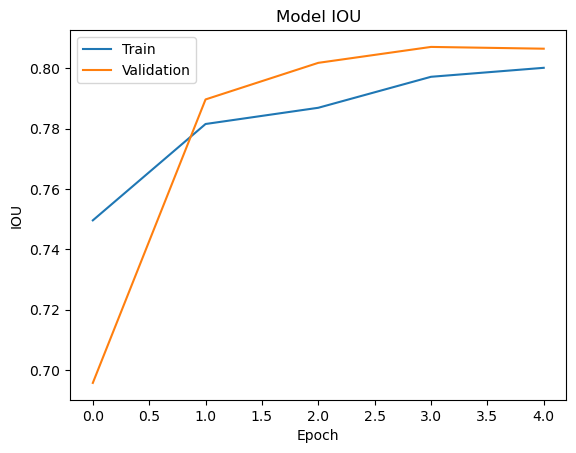

In [58]:
history_file = 'C:/Users/JAYANT/Downloads/History_UR.npy'
plotHistory(history_file)

##### c) ResNet50

In [59]:
model=ResNet_model()
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [60]:
def cosine_annealing(x):
    lr = 0.001
    epochs = 10
    return lr*(np.cos(np.pi * x/epochs) + 1.) / 2

learning_rate = LearningRateScheduler(cosine_annealing)
stop = EarlyStopping(monitor = 'loss', mode = 'min', patience = 3)

checkpoint_or = ModelCheckpoint('onlyres-{epoch:02d}-{val_mean_iou:.2f}.h5', monitor = 'loss',
                             verbose = 1, mode = 'min', save_best_only = True,
                             save_weights_only = True)

model.compile(optimizer = adamopt_r, loss = iou_loss, metrics = [mean_iou])

history_ures = model.fit_generator(generator = trainUNet, epochs = 10,
                                   validation_data = validateUNet,
                                   callbacks = [learning_rate, checkpoint_or, stop],
                                   shuffle = True, verbose = 1)

Epoch 1/10
1500/1500 [==============================] - 4223s 3s/step - loss: 0.8766 - mean_iou: 0.8358 - val_loss: 0.9049 - val_mean_iou: 0.8780

Epoch 00001: loss improved from inf to 0.87664, saving model to onlyres-01-0.88.h5
Epoch 2/10
1500/1500 [==============================] - 4048s 3s/step - loss: 0.8778 - mean_iou: 0.9068 - val_loss: 0.9049 - val_mean_iou: 0.8780

Epoch 00002: loss did not improve from 0.87664
Epoch 3/10
1500/1500 [==============================] - 4048s 3s/step - loss: 0.8778 - mean_iou: 0.9068 - val_loss: 0.9049 - val_mean_iou: 0.8780

Epoch 00003: loss did not improve from 0.87664
Epoch 4/10
1500/1500 [==============================] - 3837s 3s/step - loss: 0.8778 - mean_iou: 0.9068 - val_loss: 0.9049 - val_mean_iou: 0.8780

Epoch 00004: loss did not improve from 0.87664


In [61]:
model.load_weights('C:/Users/JAYANT/Downloads/onlyres-01-0.88.h5')

##### Predicting on the test set

In [62]:
y_test, y_predicted = predictBatches(testing_data, test_imageIdpaths, model)

Number of Test Samples: 4920
Predicting Batches Prediction Complete!


##### Confusion Matrix

In [63]:
report_file_res = pd.read_csv('C:/Users/JAYANT/Downloads/submission_3.csv')
showConfusionMatrix(report_file_res)

Predictions in terms of IOU :

Confusion Matrix:
 [[4214    0]
 [ 740    0]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.85      1.00      0.92      4214
         1.0       0.00      0.00      0.00       740

    accuracy                           0.85      4954
   macro avg       0.43      0.50      0.46      4954
weighted avg       0.72      0.85      0.78      4954



**Observation from Confusion Matrix** -


**True Positives(TP)** - 0 cases which is a point of concern. Thus, our model failed in successfully predicting the cases of Pneumonia pr cases with Lung Opacity

**True Negatives(TN)** - 4214 patients who have actually 'No Lung Opacity'/'Normal' are correctly predicted as 'Normal' or cases with no Pneumonia

**False Positives(FP)** - 0 cases who have actually 'No Lung Opacity'/'Normal' incorrectly predicted as having 'Lung Opacity'. **Type-I error is LESS** . This is a big positive point for a medical test

**False Negatives(FN)** are - 740 cases where the patients who have actually 'Lung Opacity' or 'Pneumonia' are incorrectly predicted as'Normal'. These are model mistakes.

### CONCLUSION

 - As a first step of our project, we started with **exploring the given dataset** and found how the various attributes (obtained from both the files and images) are spread across the entire dataset.
 - Then we **cleaned the dataset** for building the model.
 - In the Milestone 1 submission -  We only **built a basic CNN Model** which resulted very less accuracy because it was only a classification model without any fine tuning and data augmentation.
 
 
 - In the Milestone 2 -  We tried **fine tuning the basic CNN Model** by changing the learning rate, optimizer and just using resnet without transer learning.
 - Further, we found that U-Net is also widely used in medical applications.We applied the **Transfer learning methods using U Net - MobileNet & ResNet**. (Classification + Localization)
 
 
 - a) **UNet with MobileNet** - accuracy 87% with 117 false positive and 623 false negative.
 - b) **UNet with ResNet** - accuracy of 87% with 101 false positive and 639 false negtive.
 - c) **ResNet** - accuracy of 85% with 0 false positive and false Negative. 
 
 
 - **CONCLUSION**: UNet with both MobileNet & ResNet50 gives us better accuracy when compared to just basic CNN model and ResNet50